# Lung‐CT Malignancy Classifier — Backbone Screening

**Objective** Quickly pinpoint which pretrained CNN backbone (MobileNet V2, ConvNeXt-Tiny, EfficientNet-B4, DenseNet-121) gives the highest **balanced accuracy (BA)** on a five-class lung-(full&nodule) malignancy task, before investing time in fine-tuning.

**Method in 5 bullets**
1. **Load & inspect data** Excel metadata ＋ NPZ arrays with 224 × 224 crops.  
2. **Prep** RGB-expand, 80 / 20 stratified split, one-hot labels.  
3. **Balanced training pipeline** `tf.data` sampler + moderate on-the-fly augments → evens out class counts.  
4. **Freeze-% grid search** For each backbone test {0, 20, 40, 60, 80, 100 %} frozen layers; early-stop on val Balanced Accuracy.  
5. **Analyse** Confusion matrices, BA & macro-AUPRC curves, heat-maps, and a tidy results DataFrame.

> **Why freezes?** The design mirrors the layer-transfer study by Yosinski et al., 2014, which shows how feature generality falls as you climb the network.

## Import Libraries
Import required libraries, define a RAM-trimming function, and enable mixed precision

In [ ]:
import os
import gc
import ctypes
import random
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input as preprocess_convnext
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as preprocess_densenet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_mobilenet
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_recall_curve,
    auc
)


def trim_ram():
    libc = ctypes.CDLL("libc.so.6")
    result = libc.malloc_trim(0)
    tf.keras.backend.clear_session()
    plt.close("all")
    gc.collect()
    print("malloc_trim result:", result)


mixed_precision.set_global_policy("mixed_float16")

2025-04-26 16:09:17.123039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745683757.319107      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745683757.379368      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data
### Load Excel File
Load the lung dataset from Excel into a DataFrame and display its contents and shape

In [ ]:
file_path = '/kaggle/input/ai-in-biomed-dataset-lung/dataset_lung.xlsx'
df = pd.read_excel(file_path)

print(df)
print(f"File shape: {df.shape}")

                  Full_slice               Nodule  TumorClass
0        pat1_fullslice.nrrd     pat1_nodule.nrrd           5
1        pat2_fullslice.nrrd     pat2_nodule.nrrd           5
2        pat3_fullslice.nrrd     pat3_nodule.nrrd           2
3        pat4_fullslice.nrrd     pat4_nodule.nrrd           5
4        pat5_fullslice.nrrd     pat5_nodule.nrrd           4
...                      ...                  ...         ...
2358  pat2368_fullslice.nrrd  pat2368_nodule.nrrd           2
2359  pat2369_fullslice.nrrd  pat2369_nodule.nrrd           2
2360  pat2387_fullslice.nrrd  pat2387_nodule.nrrd           5
2361  pat2399_fullslice.nrrd  pat2399_nodule.nrrd           5
2362  pat2415_fullslice.nrrd  pat2415_nodule.nrrd           5

[2363 rows x 3 columns]
File shape: (2363, 3)


### Load Images
Load full‐slice and nodule datasets from NPZ files and display their shapes

In [ ]:
fullz = np.load('/kaggle/input/ai-in-biomed-dataset-lung/fullslice_dataset.npz', allow_pickle=True)
X_full, y_full = fullz['X'], fullz['y']
del fullz
nodz = np.load('/kaggle/input/ai-in-biomed-dataset-lung/nodule_dataset.npz', allow_pickle=True)
X_nodule, y_nodule = nodz['X'], nodz['y']
del nodz

print(f"Full-slice: X_full.shape = {X_full.shape}, y_full.shape = {y_full.shape}")
print(f"Nodule:     X_nodule.shape = {X_nodule.shape}, y_nodule.shape = {y_nodule.shape}")

Full-slice: X_full.shape = (2363, 224, 224), y_full.shape = (2363,)
Nodule:     X_nodule.shape = (2363, 224, 224), y_nodule.shape = (2363,)


## Prepare Data for Deep Learning Phase
Expand images to 3 channels, split into training/validation sets, adjust labels, and one-hot encode

In [ ]:
def prepare_data(X, y):
    X_3D = np.repeat(X[..., np.newaxis], 3, axis=-1)
    X_train, X_val, y_train, y_val = train_test_split(
        X_3D, y, test_size=0.2, stratify=y, random_state=42
    )
    y_train -= 1
    y_val -= 1
    print(f"Train shape: {X_train.shape}, {y_train.shape}")
    print(f"Val   shape: {X_val.shape}, {y_val.shape}")
    print(f"Unique y_train: {np.unique(y_train)}")
    print(f"Unique y_val:   {np.unique(y_val)}")
    y_train_cat = tf.keras.utils.to_categorical(y_train, 5)
    y_val_cat = tf.keras.utils.to_categorical(y_val, 5)
    return X_train, X_val, y_train_cat, y_val_cat

X_train, X_val, y_train_cat, y_val_cat = prepare_data(X_full, y_full)
# X_train, X_val, y_train_cat, y_val_cat = prepare_data(X_nodule, y_nodule)

Train shape: (1890, 224, 224, 3), (1890,)
Val   shape: (473, 224, 224, 3), (473,)
Unique y_train: [0 1 2 3 4]
Unique y_val:   [0 1 2 3 4]


# Backbone Screening - Full

### Functions
Define callbacks for balanced accuracy, build a balanced data pipeline with augmentation, and implement evaluation and plotting utilities

In [ ]:
class SaveBestBalancedAcc(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, patience=3):
        super().__init__()
        self.val_ds = val_ds
        self.patience = patience
        self.best_acc = -np.inf
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        acc = compute_balanced_acc(self.model, self.val_ds)
        print(f"\n→ Val balanced_accuracy: {acc:.4f}")
        if acc > self.best_acc:
            self.best_acc = acc
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print("No improvement—stopping early.")
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            print(f"Restoring best weights (balanced_acc={self.best_acc:.4f})")
            self.model.set_weights(self.best_weights)


def make_balanced_dataset(X, y_idx, num_classes, batch_size, autotune=tf.data.AUTOTUNE):
    base_ds = tf.data.Dataset.from_tensor_slices((X, y_idx))
    class_datasets = [
        base_ds.filter(lambda img, lbl, c=c: tf.equal(lbl, c)).repeat()
        for c in range(num_classes)
    ]
    balanced = tf.data.experimental.sample_from_datasets(
        class_datasets, weights=[1/num_classes]*num_classes
    )

    rot_layer = RandomRotation(factor=0.04, fill_mode='reflect')
    shift_layer = RandomTranslation(height_factor=0.08, width_factor=0.08, fill_mode='reflect')
    zoom_layer = RandomZoom(height_factor=(-0.10, 0.10), width_factor=(-0.10, 0.10), fill_mode='reflect')

    def _augment(img, lbl):
        img = tf.image.random_flip_left_right(tf.image.convert_image_dtype(img, tf.float32))
        img = rot_layer(img)
        img = shift_layer(img)
        img = zoom_layer(img)
        img = tf.image.random_contrast(img, 0.85, 1.15)
        return img, tf.one_hot(lbl, num_classes)

    return (
        balanced
        .map(_augment, num_parallel_calls=autotune)
        .batch(batch_size, drop_remainder=True)
        .prefetch(autotune)
        .apply(tf.data.experimental.prefetch_to_device("/gpu:0"))
    )


def compute_balanced_acc(model, dataset):
    y_true, y_pred = [], []
    for x, y in dataset:
        probs = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(probs, axis=1))
        y_true.extend(np.argmax(y.numpy(), axis=1))
    return balanced_accuracy_score(y_true, y_pred)


def compute_macro_auprc(y_true_onehot, y_prob):
    pr_aucs = []
    for c in range(y_true_onehot.shape[1]):
        prec, rec, _ = precision_recall_curve(y_true_onehot[:, c], y_prob[:, c])
        pr_aucs.append(auc(rec, prec))
    return np.mean(pr_aucs)


def evaluate_model(model, val_ds, num_classes):
    probs, trues = [], []
    for x, y in val_ds:
        probs.append(model.predict(x, verbose=0))
        trues.append(y.numpy())
    y_prob = np.vstack(probs)
    y_true = np.vstack(trues)
    preds = np.argmax(y_prob, axis=1)
    labels = np.argmax(y_true, axis=1)
    return {
        "balanced_accuracy": balanced_accuracy_score(labels, preds),
        "macro_auprc": compute_macro_auprc(y_true, y_prob),
        "y_true": labels,
        "y_pred": preds
    }


def plot_confusion_matrix(y_true, y_pred, num_classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    ticks = np.arange(num_classes)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

    plt.tight_layout()
    plt.show()

Define functions for freezing experiments, evaluation, and metric plotting

In [ ]:
def _plot_metric_curves(freeze_percents, accs, auprcs, title, ax=None):
    """Draw BA and AUPRC curves on the same axes."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(freeze_percents, accs, marker='o', label='Balanced Acc')
    ax.set_xlabel('Freeze percentage (%)')
    ax.set_ylabel('Balanced accuracy', color='C0')
    ax.tick_params(axis='y', labelcolor='C0')
    ax.set_ylim(0, 1)

    ax2 = ax.twinx()
    ax2.plot(freeze_percents, auprcs, marker='s', ls='--', label='Macro AUPRC')
    ax2.set_ylabel('Macro AUPRC', color='C1')
    ax2.tick_params(axis='y', labelcolor='C1')
    ax2.set_ylim(0, 1)

    ax.set_title(title)
    lines = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='lower right')
    ax.grid(True)
    fig.tight_layout()
    return fig

def build_model_with_freeze(backbone_cls, preprocess_fn, input_shape, num_classes, freeze_percent):
    inp = tf.keras.Input(shape=input_shape, name='image')
    x = layers.Lambda(preprocess_fn, name='preprocess')(inp)
    base = backbone_cls(
        include_top=False,
        weights=None if backbone_cls.__name__.startswith('Swin') else 'imagenet',
        input_tensor=x,
        input_shape=input_shape,
        pooling='avg'
    )
    layers_list = base.layers
    total = len(layers_list)
    if backbone_cls.__name__.startswith('Swin'):
        num_blocks = 4
        freeze_count = int(freeze_percent / 100 * num_blocks) * (total // num_blocks)
    else:
        freeze_count = int(freeze_percent / 100 * total)

    for i, lyr in enumerate(layers_list):
        lyr.trainable = i >= freeze_count

    out = layers.Dense(num_classes, activation='softmax')(base.output)
    model = models.Model(inp, out, name=f'{backbone_cls.__name__}_freeze{freeze_percent}')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy')
    return model

def run_freeze_experiments(
    backbones, X_train, y_train_cat, X_val, y_val_cat,
    input_shape=(224, 224, 3), num_classes=5,
    freeze_percents=(0, 10, 20, 30, 40, 50, 60, 70),
    epochs=10, patience=3, batch_size=32, autotune=tf.data.AUTOTUNE
):
    """Train each backbone across a grid of freeze percentages."""
    y_train_idx = np.argmax(y_train_cat, axis=1)
    train_ds = make_balanced_dataset(X_train, y_train_idx, num_classes, batch_size, autotune)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).batch(batch_size).prefetch(autotune)
    results = []

    for name, cls, prep in backbones:
        accs, auprcs = [], []
        for pct in freeze_percents:
            print(f"\n=== {name} | Freeze {pct}% ===")
            model = build_model_with_freeze(cls, prep, input_shape, num_classes, pct)
            cb = SaveBestBalancedAcc(val_ds, patience=patience)
            model.fit(train_ds, epochs=epochs, steps_per_epoch=len(X_train)//batch_size, callbacks=[cb], verbose=1)
            res = evaluate_model(model, val_ds, num_classes)
            ba, ma = res['balanced_accuracy'], res['macro_auprc']
            print(f"Freeze {pct}% → BA={ba:.4f}, AUPRC={ma:.4f}")
            plot_confusion_matrix(res['y_true'], res['y_pred'], num_classes, title=f"{name} | Freeze {pct}%")
            accs.append(ba); auprcs.append(ma)
            results.append({
                'backbone': name, 'freeze_percent': pct,
                'balanced_accuracy': ba, 'macro_auprc': ma,
                'trainable_pct': sum(l.trainable for l in model.layers) / len(model.layers) * 100
            })
            trim_ram()

        _plot_metric_curves(freeze_percents, accs, auprcs, title=f'{name} – metrics vs freeze %')
        plt.show()
        trim_ram()

    plt.figure(figsize=(6, 4))
    for name in sorted({r['backbone'] for r in results}):
        sub = [r for r in results if r['backbone'] == name]
        plt.plot([r['freeze_percent'] for r in sub],
                 [r['balanced_accuracy'] for r in sub],
                 marker='o', label=name)
    plt.title('Balanced accuracy vs freeze % – all models')
    plt.xlabel('Freeze percentage (%)')
    plt.ylabel('Balanced accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

selected_backbones = [
    ('MobileNetV2', MobileNetV2, preprocess_mobilenet),
    ('ConvNeXtTiny', ConvNeXtTiny, preprocess_convnext),
    ('EfficientNetB4', EfficientNetB4, preprocess_efficientnet),
    ('DenseNet121', DenseNet121, preprocess_densenet)
]

### Train and Screen
Run freezing-percentage experiments on each backbone and display the results

I0000 00:00:1745683783.397877      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=== MobileNetV2 | Freeze 0% ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


I0000 00:00:1745683830.031391      59 service.cc:148] XLA service 0x7b7838004430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745683830.032374      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745683834.406293      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/59 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.7256    

I0000 00:00:1745683856.274073      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.7356
→ Val balanced_accuracy: 0.2305
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 421ms/step - loss: 1.7344
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 1.5181
→ Val balanced_accuracy: 0.1880
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - loss: 1.5178
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 1.4566
→ Val balanced_accuracy: 0.1932
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - loss: 1.4561
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1.3736
→ Val balanced_accuracy: 0.1814
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - loss: 1.3731
Restoring best weights (balanced_acc=0.2305)
Freeze 0% → BA=0.2305, AUPRC=0.2169


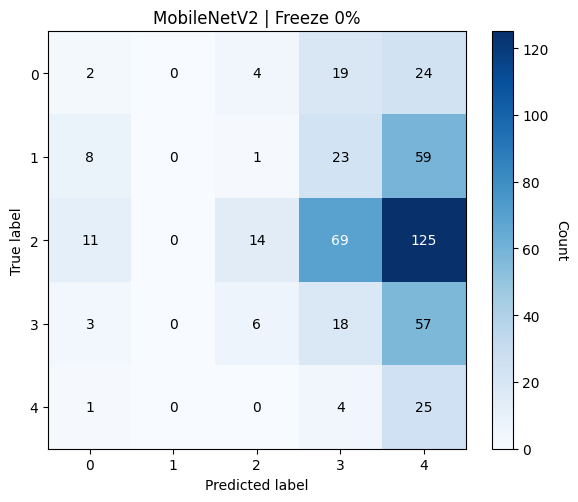

malloc_trim result: 1

=== MobileNetV2 | Freeze 20% ===
Epoch 1/10


E0000 00:00:1745683963.931768      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745683964.129039      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 1.7603
→ Val balanced_accuracy: 0.1966
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - loss: 1.7586
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.5575
→ Val balanced_accuracy: 0.1959
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 1.5569
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 1.4684
→ Val balanced_accuracy: 0.2014
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - loss: 1.4678
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 1.3732
→ Val balanced_accuracy: 0.1980
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - loss: 1.3730
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 1.2963
→ Val balanced_accuracy: 0.2173
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - loss: 1.2957
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 1.1871
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - loss: 1.1868
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 1.1798
→ Val ba

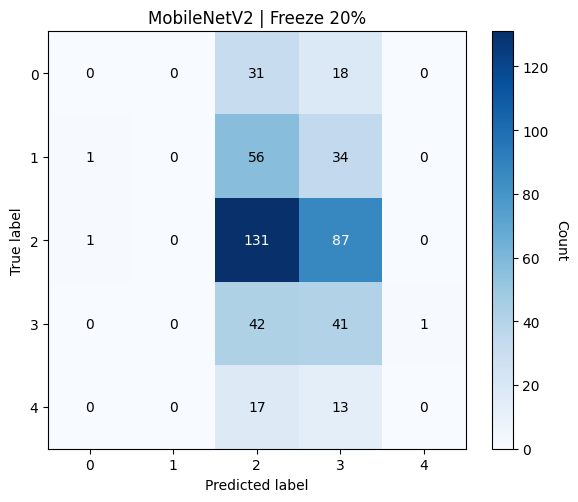

malloc_trim result: 1

=== MobileNetV2 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 1.7280
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 377ms/step - loss: 1.7267
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 1.5547
→ Val balanced_accuracy: 0.1952
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - loss: 1.5544
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.4727
→ Val balanced_accuracy: 0.2434
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - loss: 1.4723
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 1.4026
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - loss: 1.4022
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1.3281
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 1.3278
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 1.2564
→ Val balanced_accuracy: 0.2000
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 237

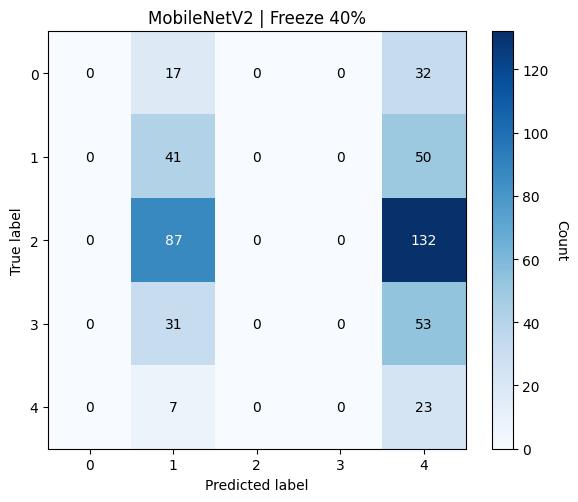

malloc_trim result: 1

=== MobileNetV2 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 1.7148
→ Val balanced_accuracy: 0.1971
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 360ms/step - loss: 1.7141
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.6117
→ Val balanced_accuracy: 0.2052
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 1.6110
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.5434
→ Val balanced_accuracy: 0.2017
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - loss: 1.5428
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.4741
→ Val balanced_accuracy: 0.1971
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - loss: 1.4738
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.4355
→ Val balanced_accuracy: 0.1998
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - loss: 1.4352
Restoring best weights (balanced_acc=0.2052)
Freeze 60% → BA=0.2052, AUPRC=0.1994


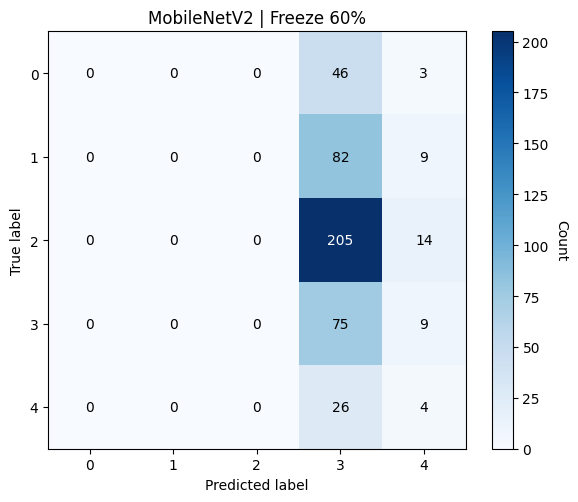

malloc_trim result: 1

=== MobileNetV2 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 1.6876
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 345ms/step - loss: 1.6869
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.5956
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - loss: 1.5955
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.5777
→ Val balanced_accuracy: 0.1978
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - loss: 1.5776
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 1.5699
→ Val balanced_accuracy: 0.2000
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - loss: 1.5697
Restoring best weights (balanced_acc=0.2000)
Freeze 80% → BA=0.2000, AUPRC=0.2200


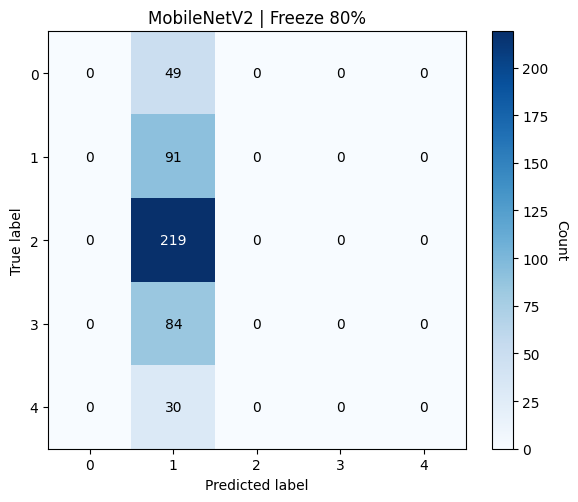

malloc_trim result: 1

=== MobileNetV2 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 1.6674
→ Val balanced_accuracy: 0.2657
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - loss: 1.6670
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.6245
→ Val balanced_accuracy: 0.2594
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - loss: 1.6245
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.6189
→ Val balanced_accuracy: 0.2991
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 1.6188
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.6074
→ Val balanced_accuracy: 0.2820
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 1.6074
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.6066
→ Val balanced_accuracy: 0.2652
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - loss: 1.6065
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.6075
→ Val balanced_accuracy: 0.2721
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 22

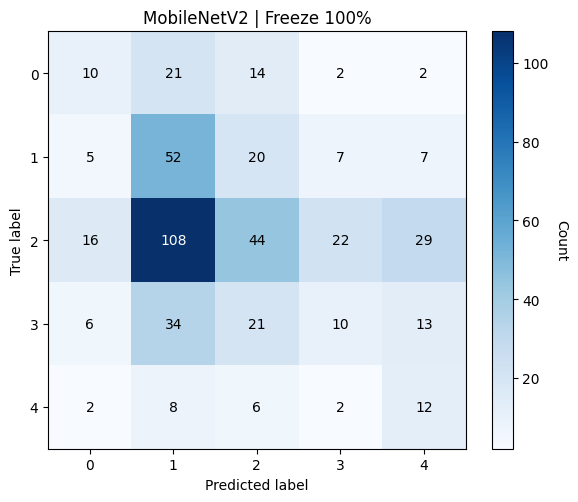

malloc_trim result: 1


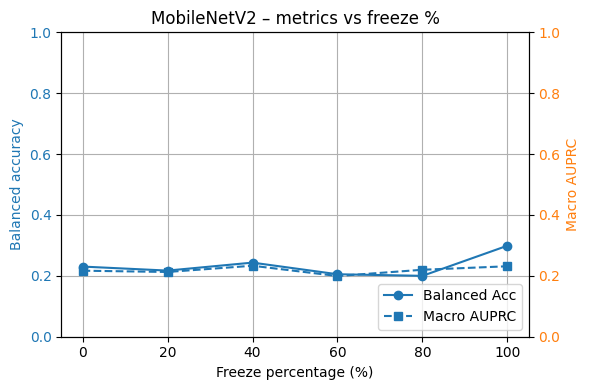

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 0% ===
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


E0000 00:00:1745684569.350558      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745684569.527101      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745684569.771027      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745684569.965766      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 1.7522
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 705ms/step - loss: 1.7507
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 1.6242
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 558ms/step - loss: 1.6242
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 1.6243
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 562ms/step - loss: 1.6243
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.6209
→ Val balanced_accuracy: 0.2000
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 562ms/step - loss: 1.6208
Restoring best weights (balanced_acc=0.2000)
Freeze 0% → BA=0.2000, AUPRC=0.2121


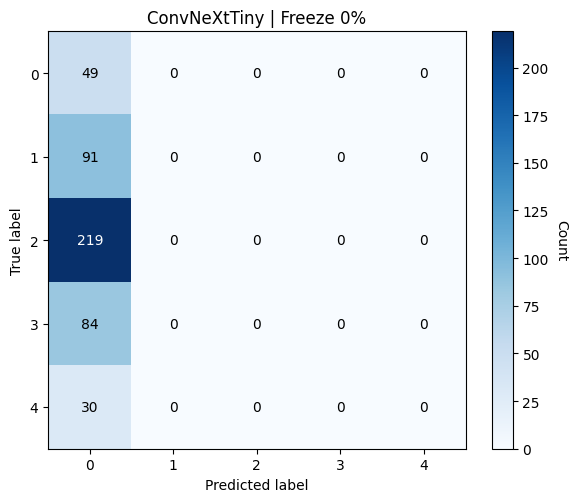

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 1.7584
→ Val balanced_accuracy: 0.2241
59/59 ━━━━━━━━━━━━━━━━━━━━ 80s 639ms/step - loss: 1.7567
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - loss: 1.5962
→ Val balanced_accuracy: 0.2756
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 497ms/step - loss: 1.5961
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 1.5657
→ Val balanced_accuracy: 0.3026
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - loss: 1.5653
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 1.4639
→ Val balanced_accuracy: 0.3444
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 507ms/step - loss: 1.4629
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 1.3365
→ Val balanced_accuracy: 0.3602
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 505ms/step - loss: 1.3358
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.2714
→ Val balanced_accuracy: 0.3506
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 498ms/step - loss: 1.2704
Epoch 7

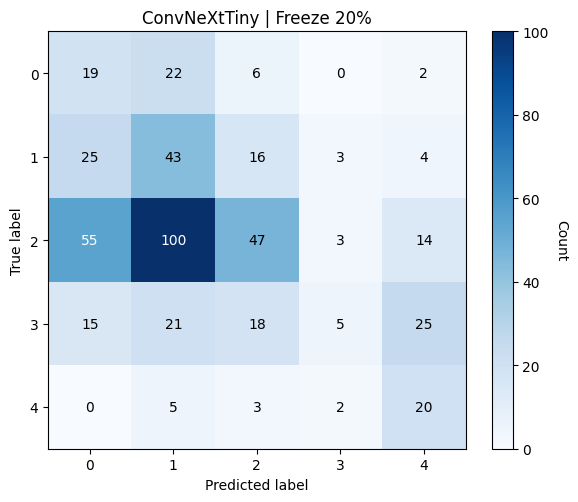

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 1.7288
→ Val balanced_accuracy: 0.3013
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 605ms/step - loss: 1.7273
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 1.5736
→ Val balanced_accuracy: 0.2820
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 445ms/step - loss: 1.5732
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 1.5104
→ Val balanced_accuracy: 0.3496
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 449ms/step - loss: 1.5099
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 1.4043
→ Val balanced_accuracy: 0.3031
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - loss: 1.4032
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 1.2930
→ Val balanced_accuracy: 0.3224
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 449ms/step - loss: 1.2918
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 1.1772
→ Val balanced_accuracy: 0.3541
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - loss: 1.1760
Epoch 7

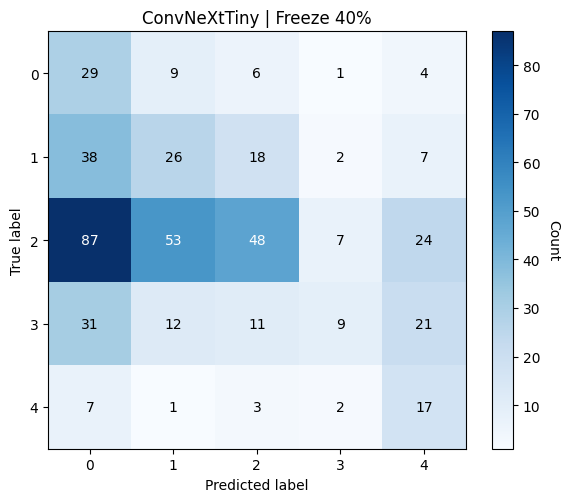

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 1.7755
→ Val balanced_accuracy: 0.2461
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - loss: 1.7736
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 1.5908
→ Val balanced_accuracy: 0.2599
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 398ms/step - loss: 1.5908
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 1.5676
→ Val balanced_accuracy: 0.2578
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step - loss: 1.5673
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 1.5273
→ Val balanced_accuracy: 0.2924
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 408ms/step - loss: 1.5267
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 1.4592
→ Val balanced_accuracy: 0.3438
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - loss: 1.4585
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 1.3880
→ Val balanced_accuracy: 0.3456
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 398ms/step - loss: 1.3871
Epoch 7

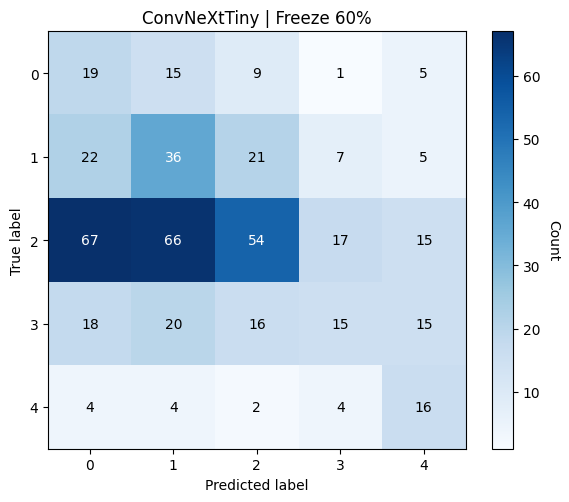

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 1.6901
→ Val balanced_accuracy: 0.2583
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 469ms/step - loss: 1.6891
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 1.5705
→ Val balanced_accuracy: 0.2654
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - loss: 1.5702
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 1.5197
→ Val balanced_accuracy: 0.2724
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - loss: 1.5193
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 1.4837
→ Val balanced_accuracy: 0.2906
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - loss: 1.4828
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 1.4019
→ Val balanced_accuracy: 0.3157
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - loss: 1.4012
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 1.2975
→ Val balanced_accuracy: 0.3297
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - loss: 1.2969
Epoch 7

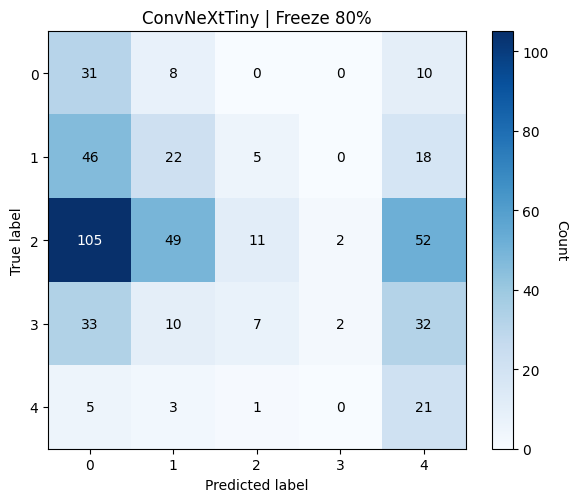

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 2.5882
→ Val balanced_accuracy: 0.2075
59/59 ━━━━━━━━━━━━━━━━━━━━ 38s 425ms/step - loss: 2.5852
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 1.9680
→ Val balanced_accuracy: 0.2070
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - loss: 1.9674
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 1.7932
→ Val balanced_accuracy: 0.2060
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 288ms/step - loss: 1.7925
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 1.6547
→ Val balanced_accuracy: 0.1902
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - loss: 1.6545
Restoring best weights (balanced_acc=0.2075)
Freeze 100% → BA=0.2075, AUPRC=0.2035


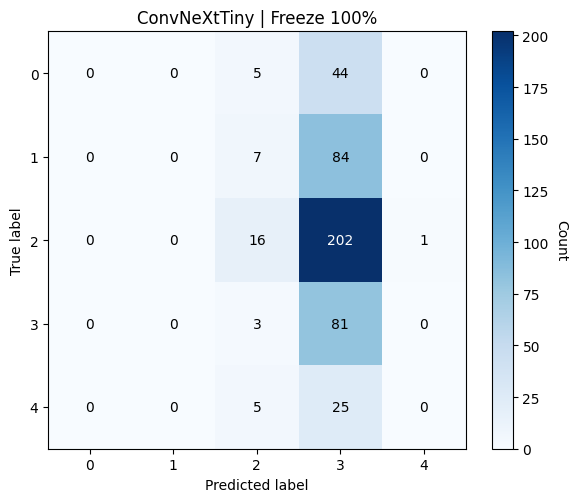

malloc_trim result: 1


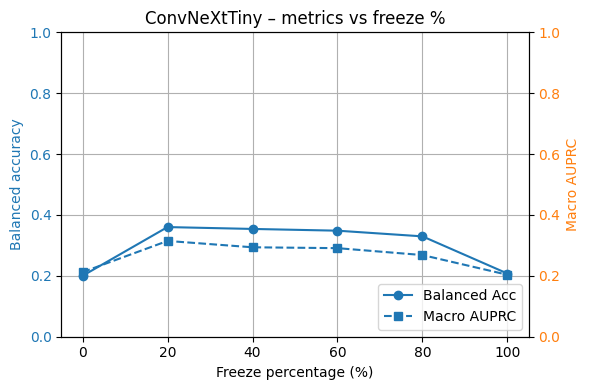

malloc_trim result: 1

=== EfficientNetB4 | Freeze 0% ===
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


E0000 00:00:1745686028.359094      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745686028.543510      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745686028.892836      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745686029.081967      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745686029.276199      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 1.6040
→ Val balanced_accuracy: 0.2041
59/59 ━━━━━━━━━━━━━━━━━━━━ 220s 940ms/step - loss: 1.6035
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 1.4748
→ Val balanced_accuracy: 0.2090
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 480ms/step - loss: 1.4741
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 1.3449
→ Val balanced_accuracy: 0.2128
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 514ms/step - loss: 1.3439
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 1.1714
→ Val balanced_accuracy: 0.2005
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 440ms/step - loss: 1.1707
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 1.0155
→ Val balanced_accuracy: 0.2031
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 512ms/step - loss: 1.0144
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.8465
→ Val balanced_accuracy: 0.2254
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 437ms/step - loss: 0.8462
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.7537
→ Val b

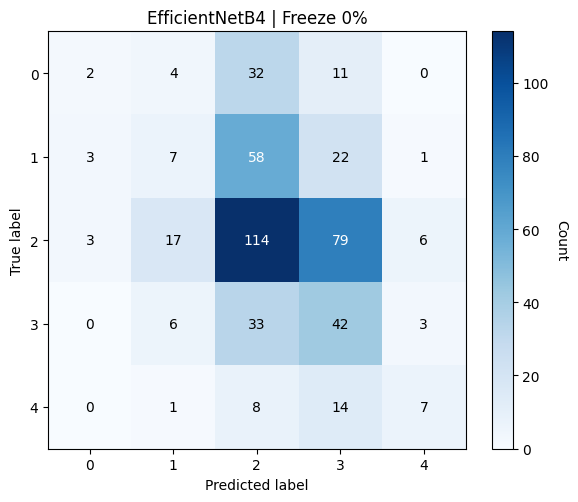

malloc_trim result: 1

=== EfficientNetB4 | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1.6278
→ Val balanced_accuracy: 0.1945
59/59 ━━━━━━━━━━━━━━━━━━━━ 178s 780ms/step - loss: 1.6275
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 1.5402
→ Val balanced_accuracy: 0.2123
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - loss: 1.5399
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 1.4630
→ Val balanced_accuracy: 0.2315
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 1.4627
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 1.3408
→ Val balanced_accuracy: 0.2839
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 1.3407
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 1.2871
→ Val balanced_accuracy: 0.2908
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - loss: 1.2865
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 1.1704
→ Val balanced_accuracy: 0.2752
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step - loss: 1.1700
Epoc

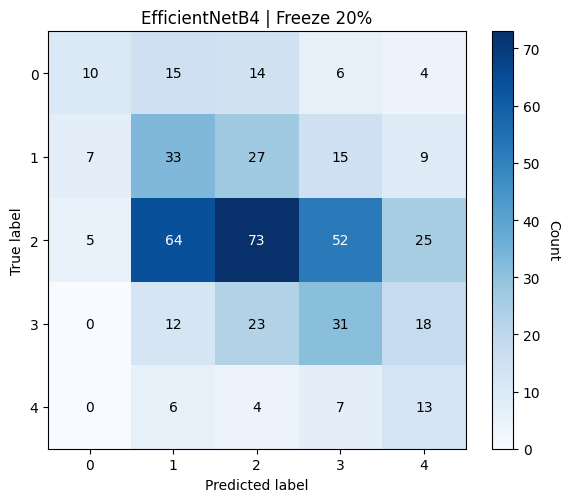

malloc_trim result: 1

=== EfficientNetB4 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 1.6402
→ Val balanced_accuracy: 0.2065
59/59 ━━━━━━━━━━━━━━━━━━━━ 154s 754ms/step - loss: 1.6401
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 1.6132
→ Val balanced_accuracy: 0.2103
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 408ms/step - loss: 1.6131
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 1.5960
→ Val balanced_accuracy: 0.2912
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - loss: 1.5957
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1.5711
→ Val balanced_accuracy: 0.2639
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - loss: 1.5712
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 1.5487
→ Val balanced_accuracy: 0.3172
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 413ms/step - loss: 1.5487
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 1.5306
→ Val balanced_accuracy: 0.2667
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - loss: 1.5305
Epoc

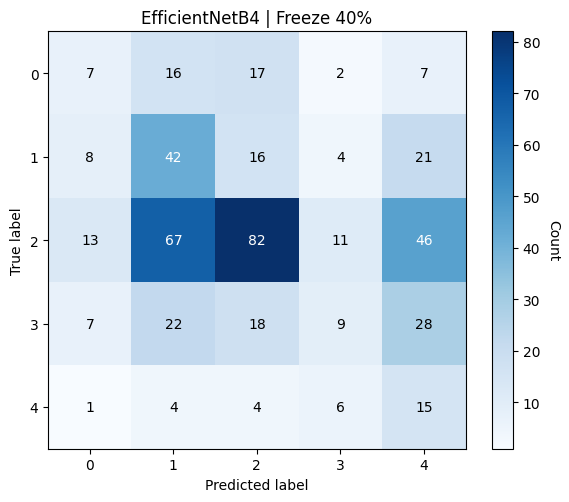

malloc_trim result: 1

=== EfficientNetB4 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 1.6462
→ Val balanced_accuracy: 0.2264
59/59 ━━━━━━━━━━━━━━━━━━━━ 131s 775ms/step - loss: 1.6461
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 1.6069
→ Val balanced_accuracy: 0.1916
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - loss: 1.6070
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 1.5986
→ Val balanced_accuracy: 0.2238
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - loss: 1.5985
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 1.5933
→ Val balanced_accuracy: 0.2256
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - loss: 1.5932
Restoring best weights (balanced_acc=0.2264)
Freeze 60% → BA=0.2264, AUPRC=0.2190


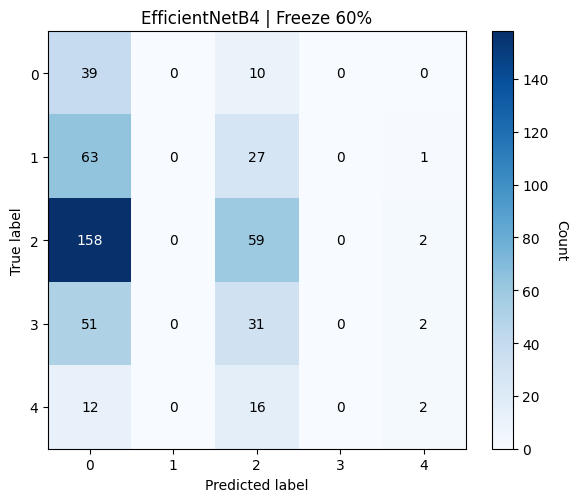

malloc_trim result: 1

=== EfficientNetB4 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.6335
→ Val balanced_accuracy: 0.1983
59/59 ━━━━━━━━━━━━━━━━━━━━ 108s 672ms/step - loss: 1.6336
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 1.6244
→ Val balanced_accuracy: 0.2087
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - loss: 1.6244
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 1.6211
→ Val balanced_accuracy: 0.2126
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - loss: 1.6211
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 1.5973
→ Val balanced_accuracy: 0.2620
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - loss: 1.5974
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.6221
→ Val balanced_accuracy: 0.2296
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - loss: 1.6220
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 1.6042
→ Val balanced_accuracy: 0.1943
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - loss: 1.6043
Epoc

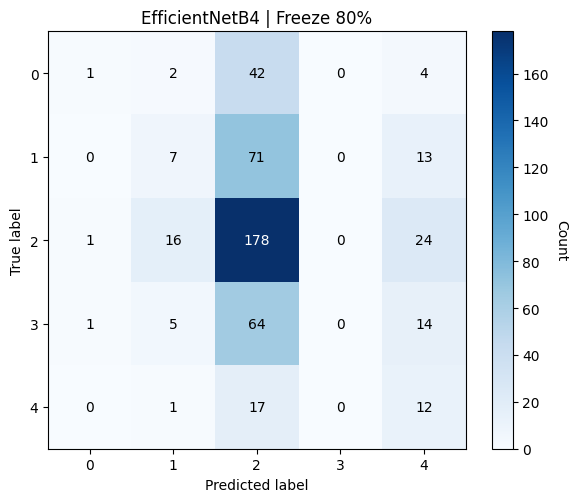

malloc_trim result: 1

=== EfficientNetB4 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 1.6153
→ Val balanced_accuracy: 0.1888
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 731ms/step - loss: 1.6153
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.6106
→ Val balanced_accuracy: 0.2090
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - loss: 1.6106
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 1.6131
→ Val balanced_accuracy: 0.1973
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - loss: 1.6131
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 1.6090
→ Val balanced_accuracy: 0.2514
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - loss: 1.6091
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 1.6126
→ Val balanced_accuracy: 0.2462
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - loss: 1.6126
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 1.6094
→ Val balanced_accuracy: 0.1929
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - loss: 1.6095
Epoc

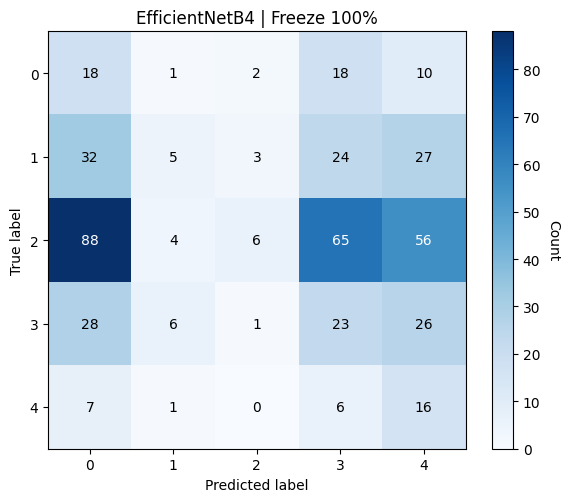

malloc_trim result: 1


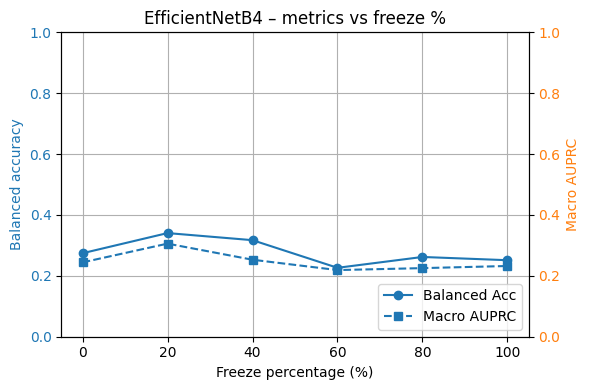

malloc_trim result: 1

=== DenseNet121 | Freeze 0% ===
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 1.8045
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 218s 835ms/step - loss: 1.8023
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 1.5405
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - loss: 1.5397
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 1.3724
→ Val balanced_accuracy: 0.1971
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - loss: 1.3720
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 1.2697
→ Val balanced_accuracy: 0.2321
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - loss: 1.2690
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 1.1893
→ Val balanced_accuracy: 0.1969
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - loss: 1.1884
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 1.0433
→ Val balanced_accuracy: 0.2341
59/59 ━━━━━━━━

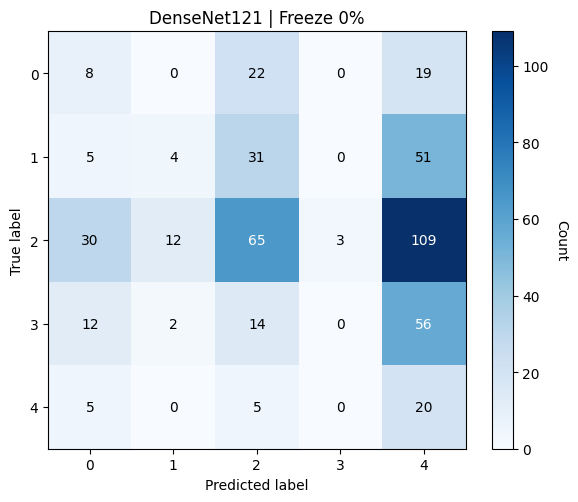

malloc_trim result: 1

=== DenseNet121 | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 1.8022
→ Val balanced_accuracy: 0.2009
59/59 ━━━━━━━━━━━━━━━━━━━━ 176s 778ms/step - loss: 1.8000
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 1.4159
→ Val balanced_accuracy: 0.3098
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - loss: 1.4155
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 1.2848
→ Val balanced_accuracy: 0.3069
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - loss: 1.2841
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 1.1607
→ Val balanced_accuracy: 0.3169
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - loss: 1.1599
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.9988
→ Val balanced_accuracy: 0.3084
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - loss: 0.9982
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.8736
→ Val balanced_accuracy: 0.3438
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - loss: 0.8736
Epoch 7

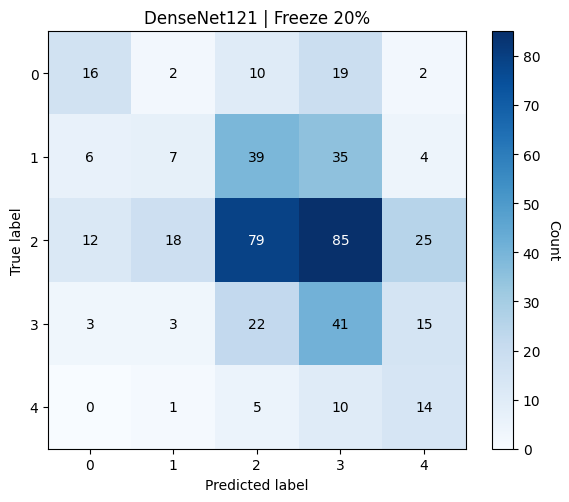

malloc_trim result: 1

=== DenseNet121 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 1.8033
→ Val balanced_accuracy: 0.2286
59/59 ━━━━━━━━━━━━━━━━━━━━ 142s 674ms/step - loss: 1.8014
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 1.5200
→ Val balanced_accuracy: 0.2329
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 292ms/step - loss: 1.5191
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 1.3914
→ Val balanced_accuracy: 0.2418
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - loss: 1.3909
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 1.2850
→ Val balanced_accuracy: 0.2637
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - loss: 1.2844
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 1.1839
→ Val balanced_accuracy: 0.3193
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 294ms/step - loss: 1.1831
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 1.0698
→ Val balanced_accuracy: 0.3080
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 1.0696
Epoch 7

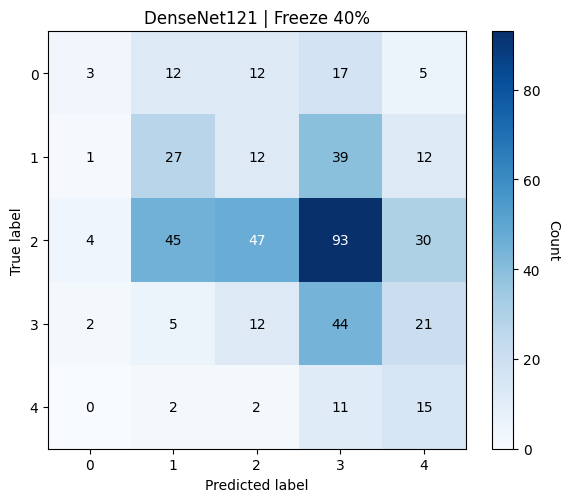

malloc_trim result: 1

=== DenseNet121 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 1.7974
→ Val balanced_accuracy: 0.2205
59/59 ━━━━━━━━━━━━━━━━━━━━ 117s 777ms/step - loss: 1.7954
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 1.5053
→ Val balanced_accuracy: 0.2317
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 292ms/step - loss: 1.5049
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 1.4046
→ Val balanced_accuracy: 0.2698
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - loss: 1.4041
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 1.3154
→ Val balanced_accuracy: 0.2865
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step - loss: 1.3149
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.1947
→ Val balanced_accuracy: 0.3241
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - loss: 1.1943
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.1146
→ Val balanced_accuracy: 0.3655
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 1.1143
Epoch 7

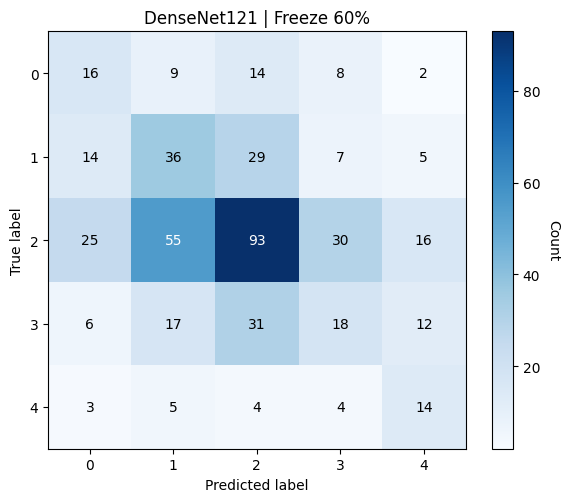

malloc_trim result: 1

=== DenseNet121 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 1.8697
→ Val balanced_accuracy: 0.2372
59/59 ━━━━━━━━━━━━━━━━━━━━ 84s 649ms/step - loss: 1.8670
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.5438
→ Val balanced_accuracy: 0.2804
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - loss: 1.5436
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1.4844
→ Val balanced_accuracy: 0.2772
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - loss: 1.4838
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 1.4194
→ Val balanced_accuracy: 0.2961
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - loss: 1.4192
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.3877
→ Val balanced_accuracy: 0.2778
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - loss: 1.3873
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 1.3188
→ Val balanced_accuracy: 0.2682
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - loss: 1.3189
Epoch 7/

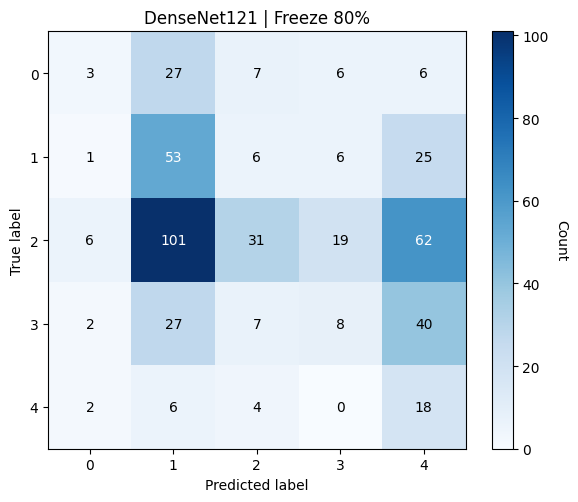

malloc_trim result: 1

=== DenseNet121 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 1.7019
→ Val balanced_accuracy: 0.2704
59/59 ━━━━━━━━━━━━━━━━━━━━ 63s 640ms/step - loss: 1.7014
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 1.6221
→ Val balanced_accuracy: 0.2600
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - loss: 1.6220
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 1.6256
→ Val balanced_accuracy: 0.2666
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - loss: 1.6255
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 1.6219
→ Val balanced_accuracy: 0.2665
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - loss: 1.6218
Restoring best weights (balanced_acc=0.2704)
Freeze 100% → BA=0.2704, AUPRC=0.2285


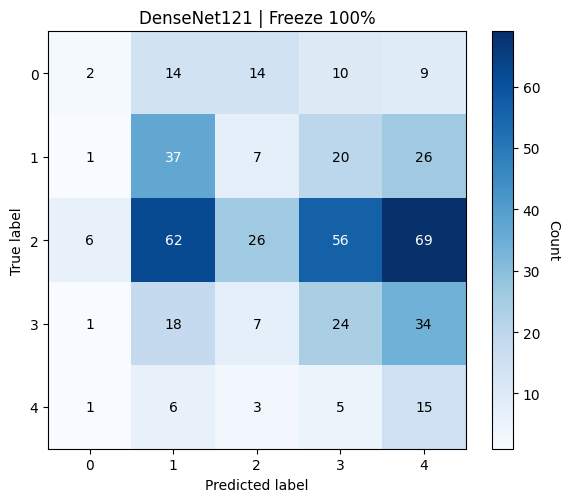

malloc_trim result: 1


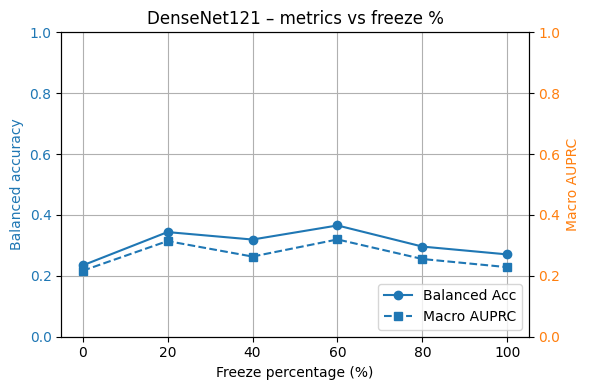

malloc_trim result: 1


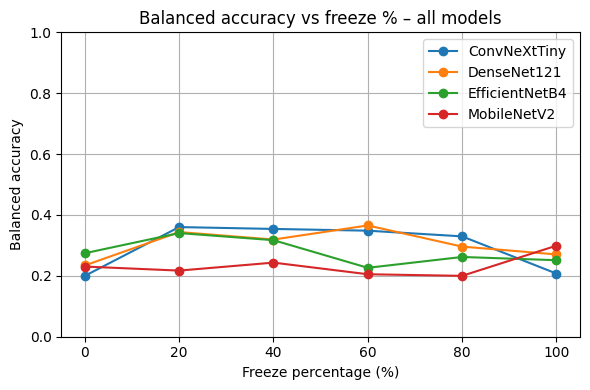

=== Freeze Experiment Results ===
          backbone  freeze_percent  balanced_accuracy  macro_auprc  \
0      MobileNetV2               0           0.230472     0.216926   
1      MobileNetV2              20           0.217254     0.212716   
2      MobileNetV2              40           0.243443     0.233202   
3      MobileNetV2              60           0.205238     0.199432   
4      MobileNetV2              80           0.200000     0.219983   
5      MobileNetV2             100           0.299094     0.231468   
6     ConvNeXtTiny               0           0.200000     0.212138   
7     ConvNeXtTiny              20           0.360217     0.314689   
8     ConvNeXtTiny              40           0.354108     0.293827   
9     ConvNeXtTiny              60           0.348368     0.290966   
10    ConvNeXtTiny              80           0.329690     0.268299   
11    ConvNeXtTiny             100           0.207469     0.203483   
12  EfficientNetB4               0           0.274324   

In [ ]:
freeze_results_df = run_freeze_experiments(
    selected_backbones,
    X_train, y_train_cat,
    X_val, y_val_cat,
    input_shape=(224, 224, 3),
    num_classes=y_train_cat.shape[1],
    freeze_percents=[0, 20, 40, 60, 80, 100],
    epochs=10,
    patience=3,
    batch_size=32,
    autotune=tf.data.AUTOTUNE
)

print("=== Freeze Experiment Results ===")
print(freeze_results_df)

## Evaluation
Analyze freeze experiment results: show top run, correlation, styled table, heatmap, and bar chart

Top run → {'freeze_percent': 60.0, 'balanced_accuracy': 0.36554898460964996}
ρ(trainable_pct, balanced_accuracy) = 0.037 (p=0.865)


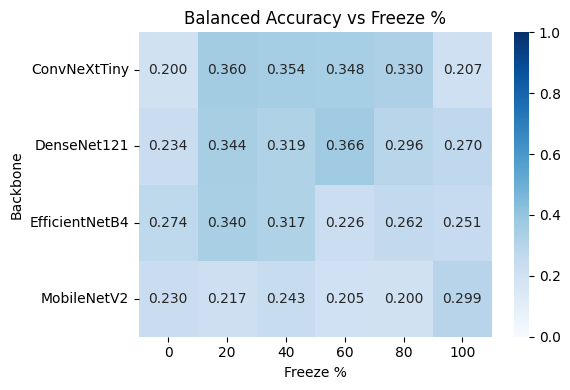

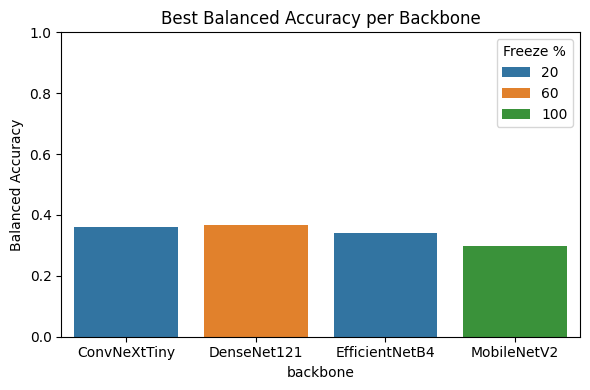

In [ ]:
def analyze_freeze_results(df: pd.DataFrame,
                           metric: str = "balanced_accuracy",
                           cmap: str = "Blues",
                           figsize: tuple = (6, 4)):

    # Top run per backbone
    by_backbone = (
        df.sort_values(metric, ascending=False)
          .groupby("backbone")
          .first()[["freeze_percent", metric]]
    )
    overall_best = by_backbone.loc[by_backbone[metric].idxmax()].to_dict()
    print(f"Top run → {overall_best}")

    # Correlation between trainable layer % and metric
    r, p = stats.pearsonr(df["trainable_pct"], df[metric])
    print(f"ρ(trainable_pct, {metric}) = {r:.3f} (p={p:.3g})")

    # Styled table highlighting best/worst per backbone
    styled = (
        df.style
          .format({metric: "{:.3f}", "macro_auprc": "{:.3f}"})
          .highlight_max(subset=[metric, "macro_auprc"], axis=0, color="#c6efce")
          .highlight_min(subset=[metric, "macro_auprc"], axis=0, color="#f2dcdb")
          .hide(axis="index")
    )

    # Heatmap of metric vs freeze %
    pivot = df.pivot(index="backbone", columns="freeze_percent", values=metric)
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap=cmap, vmin=0, vmax=1, fmt=".3f")
    plt.title(f"{metric.replace('_', ' ').title()} vs Freeze %")
    plt.ylabel("Backbone")
    plt.xlabel("Freeze %")
    plt.tight_layout()
    plt.show()

    # Bar chart of best metric per backbone
    best_rows = df.loc[df.groupby("backbone")[metric].idxmax()]
    plt.figure(figsize=figsize)
    sns.barplot(
        x="backbone",
        y=metric,
        hue="freeze_percent",
        data=best_rows,
        dodge=False
    )
    plt.ylim(0, 1)
    plt.title(f"Best {metric.replace('_', ' ').title()} per Backbone")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title="Freeze %")
    plt.tight_layout()
    plt.show()

    return styled

styled_df = analyze_freeze_results(freeze_results_df)

## Conclusion <br>

1. ConvNeXtTiny: AUC ≈ 31.922
2. DenseNet121: AUC ≈ 31.539
3. EfficientNetB4: AUC ≈ 28.179
4. MobileNetV2: AUC ≈ 22.614

⇒ ConvNeXtTiny has the largest area under the accuracy vs. freeze-percent curve

# Backbone Screening - Nodule

### Functions

Define functions for freezing experiments, evaluation, and metric plotting

In [ ]:
def _plot_metric_curves(freeze_percents, accs, auprcs, title, ax=None):
    """Draw BA and AUPRC curves on the same axes."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(freeze_percents, accs, marker='o', label='Balanced Acc')
    ax.set_xlabel('Freeze percentage (%)')
    ax.set_ylabel('Balanced accuracy', color='C0')
    ax.tick_params(axis='y', labelcolor='C0')
    ax.set_ylim(0, 1)

    ax2 = ax.twinx()
    ax2.plot(freeze_percents, auprcs, marker='s', ls='--', label='Macro AUPRC')
    ax2.set_ylabel('Macro AUPRC', color='C1')
    ax2.tick_params(axis='y', labelcolor='C1')
    ax2.set_ylim(0, 1)

    ax.set_title(title)
    lines = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='lower right')
    ax.grid(True)
    fig.tight_layout()
    return fig

def build_model_with_freeze(backbone_cls, preprocess_fn, input_shape, num_classes, freeze_percent):
    inp = tf.keras.Input(shape=input_shape, name='image')
    x = layers.Lambda(preprocess_fn, name='preprocess')(inp)
    base = backbone_cls(
        include_top=False,
        weights=None if backbone_cls.__name__.startswith('Swin') else 'imagenet',
        input_tensor=x,
        input_shape=input_shape,
        pooling='avg'
    )
    layers_list = base.layers
    total = len(layers_list)
    if backbone_cls.__name__.startswith('Swin'):
        num_blocks = 4
        freeze_count = int(freeze_percent / 100 * num_blocks) * (total // num_blocks)
    else:
        freeze_count = int(freeze_percent / 100 * total)

    for i, lyr in enumerate(layers_list):
        lyr.trainable = i >= freeze_count

    out = layers.Dense(num_classes, activation='softmax')(base.output)
    model = models.Model(inp, out, name=f'{backbone_cls.__name__}_freeze{freeze_percent}')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy')
    return model

def run_freeze_experiments(
    backbones, X_train, y_train_cat, X_val, y_val_cat,
    input_shape=(224, 224, 3), num_classes=5,
    freeze_percents=(0, 10, 20, 30, 40, 50, 60, 70),
    epochs=10, patience=3, batch_size=32, autotune=tf.data.AUTOTUNE
):
    """Train each backbone across a grid of freeze percentages."""
    y_train_idx = np.argmax(y_train_cat, axis=1)
    train_ds = make_balanced_dataset(X_train, y_train_idx, num_classes, batch_size, autotune)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat)).batch(batch_size).prefetch(autotune)
    results = []

    for name, cls, prep in backbones:
        accs, auprcs = [], []
        for pct in freeze_percents:
            print(f"\n=== {name} | Freeze {pct}% ===")
            model = build_model_with_freeze(cls, prep, input_shape, num_classes, pct)
            cb = SaveBestBalancedAcc(val_ds, patience=patience)
            model.fit(train_ds, epochs=epochs, steps_per_epoch=len(X_train)//batch_size, callbacks=[cb], verbose=1)
            res = evaluate_model(model, val_ds, num_classes)
            ba, ma = res['balanced_accuracy'], res['macro_auprc']
            print(f"Freeze {pct}% → BA={ba:.4f}, AUPRC={ma:.4f}")
            plot_confusion_matrix(res['y_true'], res['y_pred'], num_classes, title=f"{name} | Freeze {pct}%")
            accs.append(ba); auprcs.append(ma)
            results.append({
                'backbone': name, 'freeze_percent': pct,
                'balanced_accuracy': ba, 'macro_auprc': ma,
                'trainable_pct': sum(l.trainable for l in model.layers) / len(model.layers) * 100
            })
            trim_ram()

        _plot_metric_curves(freeze_percents, accs, auprcs, title=f'{name} – metrics vs freeze %')
        plt.show()
        trim_ram()

    plt.figure(figsize=(6, 4))
    for name in sorted({r['backbone'] for r in results}):
        sub = [r for r in results if r['backbone'] == name]
        plt.plot([r['freeze_percent'] for r in sub],
                 [r['balanced_accuracy'] for r in sub],
                 marker='o', label=name)
    plt.title('Balanced accuracy vs freeze % – all models')
    plt.xlabel('Freeze percentage (%)')
    plt.ylabel('Balanced accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

selected_backbones = [
    ('MobileNetV2', MobileNetV2, preprocess_mobilenet),
    ('ConvNeXtTiny', ConvNeXtTiny, preprocess_convnext),
    ('EfficientNetB4', EfficientNetB4, preprocess_efficientnet),
    ('DenseNet121', DenseNet121, preprocess_densenet)
]

### Train and Screen
Run freezing-percentage experiments on each backbone and display the results

I0000 00:00:1745675328.358490      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=== MobileNetV2 | Freeze 0% ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1745675373.797719      61 service.cc:148] XLA service 0x7a2acc092dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745675373.799332      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745675378.220240      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/59 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 1.7209    

I0000 00:00:1745675400.008639      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1.5824
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 409ms/step - loss: 1.5799
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 1.1810
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - loss: 1.1804
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 1.0363
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - loss: 1.0359
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.9355
→ Val balanced_accuracy: 0.2000
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - loss: 0.9348
Restoring best weights (balanced_acc=0.2000)
Freeze 0% → BA=0.2000, AUPRC=0.2054


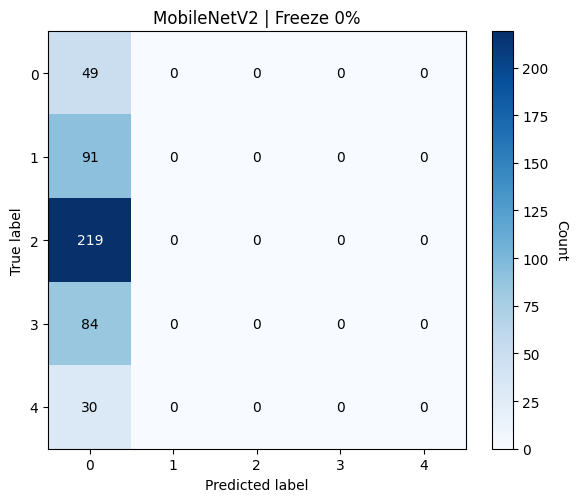

malloc_trim result: 1

=== MobileNetV2 | Freeze 20% ===
Epoch 1/10


E0000 00:00:1745675506.165261      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745675506.361838      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 1.5158
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - loss: 1.5135
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 1.1926
→ Val balanced_accuracy: 0.2350
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 1.1922
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 1.0470
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - loss: 1.0465
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.9876
→ Val balanced_accuracy: 0.1881
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - loss: 0.9872
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.8737
→ Val balanced_accuracy: 0.2022
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - loss: 0.8738
Restoring best weights (balanced_acc=0.2350)
Freeze 20% → BA=0.2350, AUPRC=0.2698


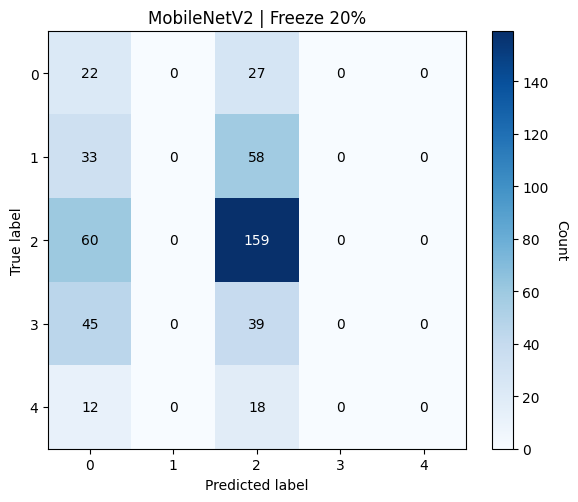

malloc_trim result: 1

=== MobileNetV2 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 1.4855
→ Val balanced_accuracy: 0.2103
59/59 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - loss: 1.4836
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 1.1777
→ Val balanced_accuracy: 0.2041
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 1.1774
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.0800
→ Val balanced_accuracy: 0.2340
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - loss: 1.0795
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 1.0058
→ Val balanced_accuracy: 0.2387
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - loss: 1.0051
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.9410
→ Val balanced_accuracy: 0.2226
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - loss: 0.9407
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.8514
→ Val balanced_accuracy: 0.2213
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 0.8514
Epoch 7/

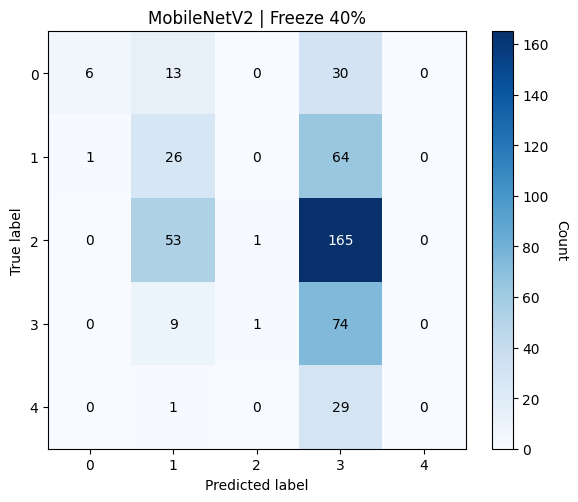

malloc_trim result: 1

=== MobileNetV2 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 1.5490
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - loss: 1.5468
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.2603
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - loss: 1.2600
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.1750
→ Val balanced_accuracy: 0.1991
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - loss: 1.1746
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 1.1039
→ Val balanced_accuracy: 0.2000
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 1.1034
Restoring best weights (balanced_acc=0.2000)
Freeze 60% → BA=0.2000, AUPRC=0.2115


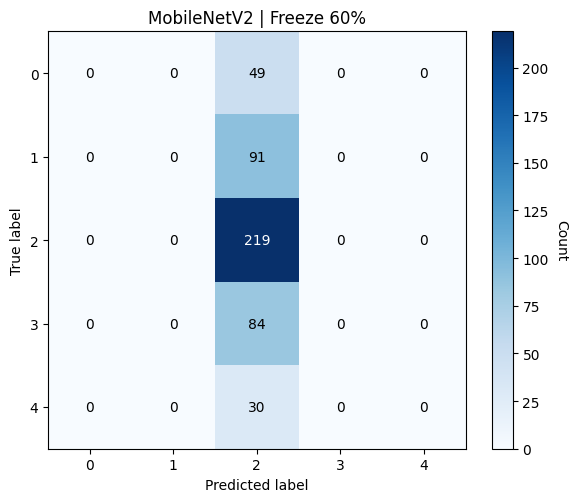

malloc_trim result: 1

=== MobileNetV2 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.5159
→ Val balanced_accuracy: 0.2684
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - loss: 1.5142
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.2806
→ Val balanced_accuracy: 0.2009
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - loss: 1.2802
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 1.2074
→ Val balanced_accuracy: 0.2000
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 234ms/step - loss: 1.2072
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 1.2095
→ Val balanced_accuracy: 0.2551
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - loss: 1.2090
Restoring best weights (balanced_acc=0.2684)
Freeze 80% → BA=0.2684, AUPRC=0.2942


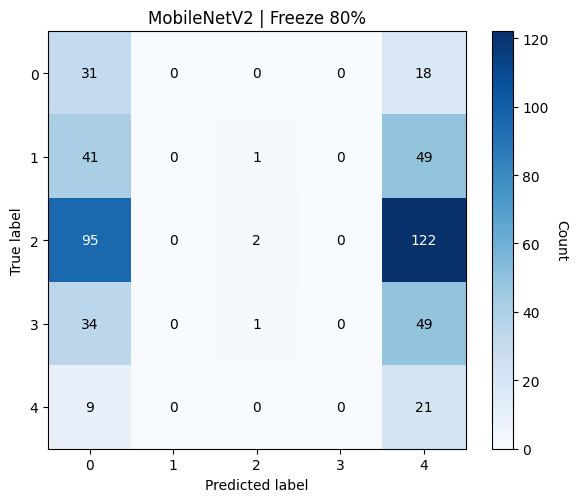

malloc_trim result: 1

=== MobileNetV2 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 1.7926
→ Val balanced_accuracy: 0.2152
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 366ms/step - loss: 1.7910
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 1.6191
→ Val balanced_accuracy: 0.2307
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 1.6190
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 1.6022
→ Val balanced_accuracy: 0.2645
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - loss: 1.6022
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.5882
→ Val balanced_accuracy: 0.2598
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - loss: 1.5882
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.5820
→ Val balanced_accuracy: 0.2533
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 1.5820
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 1.5798
→ Val balanced_accuracy: 0.2555
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 22

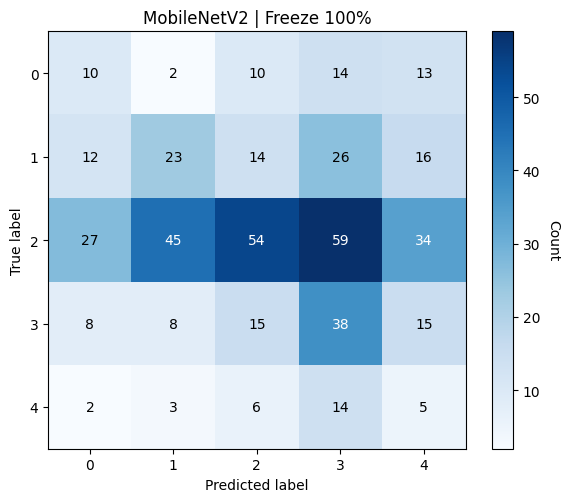

malloc_trim result: 1


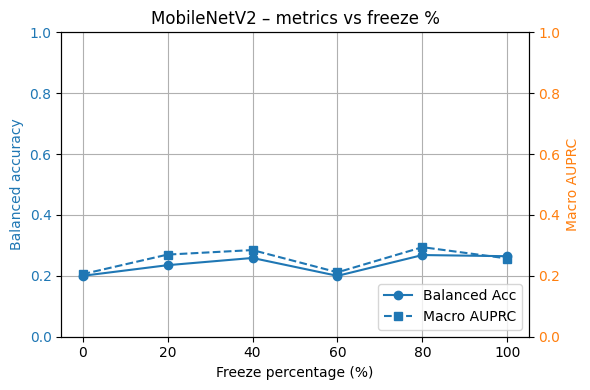

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 0% ===
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


E0000 00:00:1745676100.951303      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745676101.127483      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745676101.367857      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745676101.561221      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 1.5658
→ Val balanced_accuracy: 0.4207
59/59 ━━━━━━━━━━━━━━━━━━━━ 96s 703ms/step - loss: 1.5631
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - loss: 1.2034
→ Val balanced_accuracy: 0.4759
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 562ms/step - loss: 1.2026
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 1.0892
→ Val balanced_accuracy: 0.4721
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 554ms/step - loss: 1.0880
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 0.9605
→ Val balanced_accuracy: 0.4847
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 566ms/step - loss: 0.9596
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 0.7782
→ Val balanced_accuracy: 0.4760
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 552ms/step - loss: 0.7779
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 0.7061
→ Val balanced_accuracy: 0.4554
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 556ms/step - loss: 0.7059
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 0.5862
→ Val ba

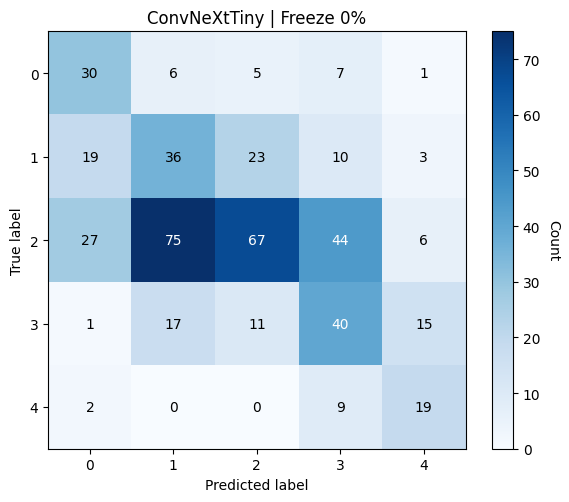

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.5670
→ Val balanced_accuracy: 0.4735
59/59 ━━━━━━━━━━━━━━━━━━━━ 79s 631ms/step - loss: 1.5644
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - loss: 1.1744
→ Val balanced_accuracy: 0.4551
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 492ms/step - loss: 1.1738
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 1.0264
→ Val balanced_accuracy: 0.4693
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 499ms/step - loss: 1.0255
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - loss: 0.9033
→ Val balanced_accuracy: 0.4696
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 501ms/step - loss: 0.9024
Restoring best weights (balanced_acc=0.4735)
Freeze 20% → BA=0.4735, AUPRC=0.4187


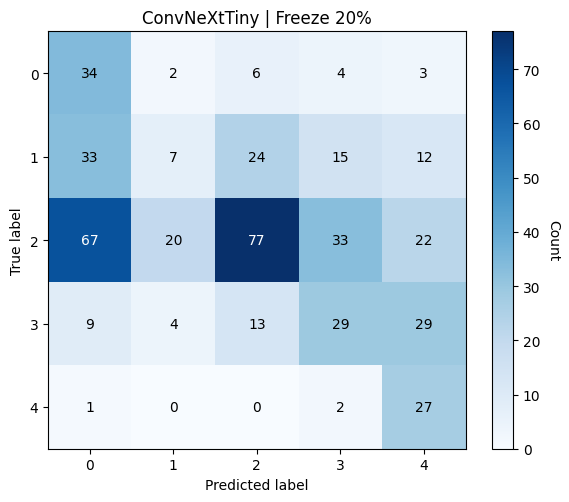

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 1.5663
→ Val balanced_accuracy: 0.4562
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 609ms/step - loss: 1.5641
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 1.1923
→ Val balanced_accuracy: 0.4503
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - loss: 1.1915
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 1.0239
→ Val balanced_accuracy: 0.4467
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 449ms/step - loss: 1.0231
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.9105
→ Val balanced_accuracy: 0.4946
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 451ms/step - loss: 0.9096
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.7826
→ Val balanced_accuracy: 0.4644
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 445ms/step - loss: 0.7823
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.7334
→ Val balanced_accuracy: 0.4424
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 444ms/step - loss: 0.7331
Epoch 7

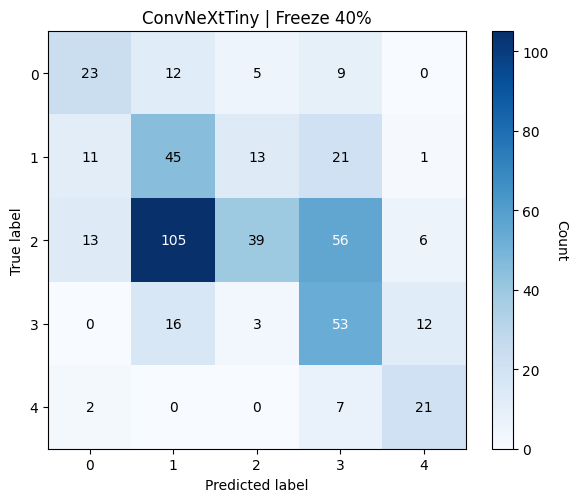

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 1.7108
→ Val balanced_accuracy: 0.4210
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 528ms/step - loss: 1.7070
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 1.2345
→ Val balanced_accuracy: 0.4814
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - loss: 1.2340
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 1.0915
→ Val balanced_accuracy: 0.4818
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - loss: 1.0908
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.9621
→ Val balanced_accuracy: 0.4629
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - loss: 0.9613
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - loss: 0.8683
→ Val balanced_accuracy: 0.4480
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - loss: 0.8680
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.7673
→ Val balanced_accuracy: 0.4429
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 39

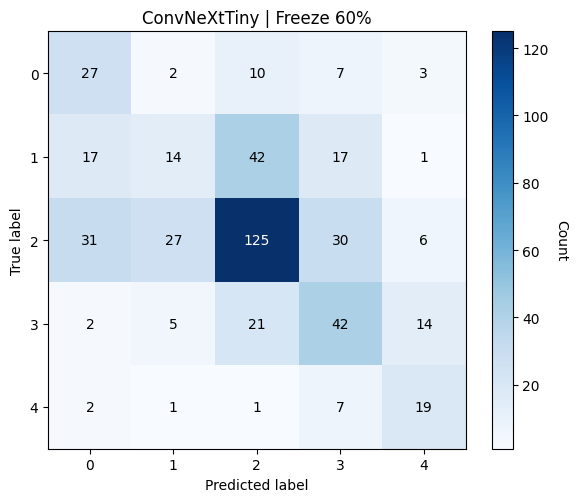

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1.5976
→ Val balanced_accuracy: 0.4267
59/59 ━━━━━━━━━━━━━━━━━━━━ 50s 474ms/step - loss: 1.5954
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 1.2559
→ Val balanced_accuracy: 0.4487
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - loss: 1.2553
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 1.1138
→ Val balanced_accuracy: 0.4583
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 349ms/step - loss: 1.1133
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 1.0244
→ Val balanced_accuracy: 0.4494
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - loss: 1.0235
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.9264
→ Val balanced_accuracy: 0.4776
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - loss: 0.9261
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.8791
→ Val balanced_accuracy: 0.4679
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - loss: 0.8785
Epoch 7

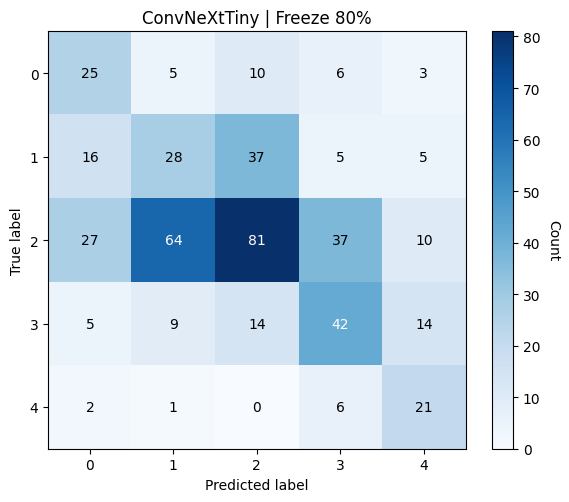

malloc_trim result: 1

=== ConvNeXtTiny | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 1.8915
→ Val balanced_accuracy: 0.2037
59/59 ━━━━━━━━━━━━━━━━━━━━ 37s 415ms/step - loss: 1.8906
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 1.6464
→ Val balanced_accuracy: 0.2080
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - loss: 1.6464
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 1.6033
→ Val balanced_accuracy: 0.2440
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - loss: 1.6031
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 1.5683
→ Val balanced_accuracy: 0.2931
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - loss: 1.5682
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 1.5572
→ Val balanced_accuracy: 0.3190
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 289ms/step - loss: 1.5571
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 1.5475
→ Val balanced_accuracy: 0.3176
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 1.5474
Epoch 

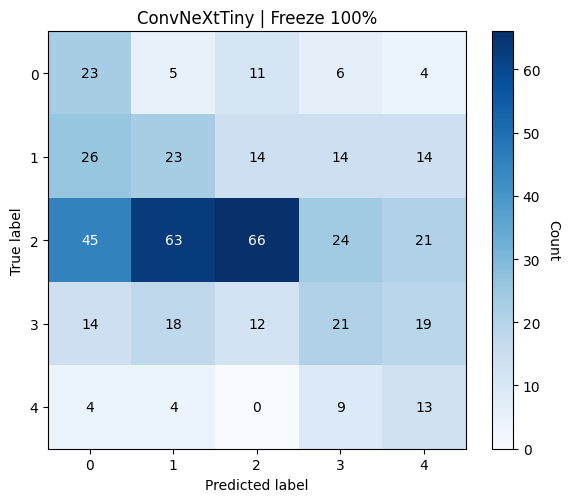

malloc_trim result: 1


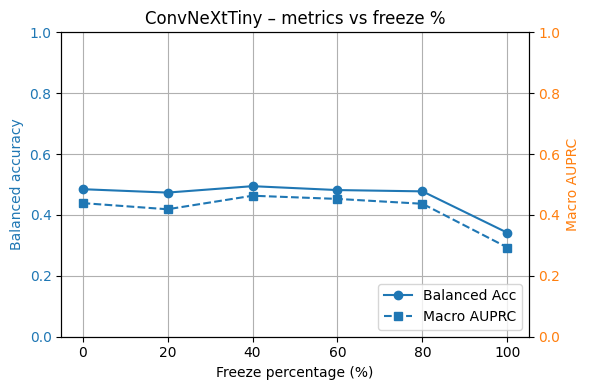

malloc_trim result: 1

=== EfficientNetB4 | Freeze 0% ===
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


E0000 00:00:1745677465.756464      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745677465.943154      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745677466.298399      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745677466.486888      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745677466.929013      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 1.5037
→ Val balanced_accuracy: 0.2058
59/59 ━━━━━━━━━━━━━━━━━━━━ 215s 931ms/step - loss: 1.5016
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 1.1106
→ Val balanced_accuracy: 0.2012
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 463ms/step - loss: 1.1098
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 0.9309
→ Val balanced_accuracy: 0.2098
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 477ms/step - loss: 0.9301
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.8186
→ Val balanced_accuracy: 0.2126
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 475ms/step - loss: 0.8177
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.6623
→ Val balanced_accuracy: 0.2637
59/59 ━━━━━━━━━━━━━━━━━━━━ 28s 473ms/step - loss: 0.6617
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 0.5821
→ Val balanced_accuracy: 0.2516
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 461ms/step - loss: 0.5816
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 0.4620
→ Val b

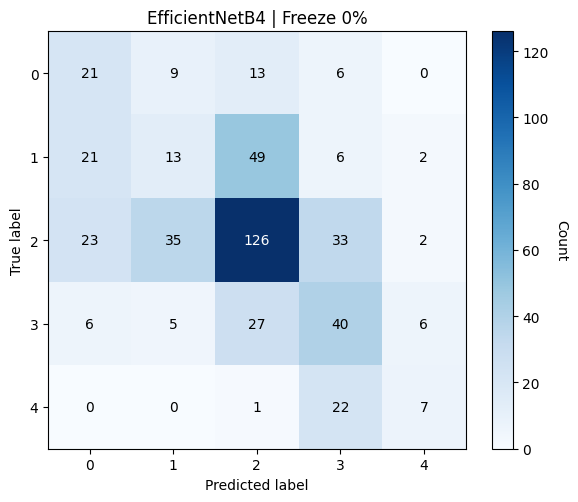

malloc_trim result: 1

=== EfficientNetB4 | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 1.4996
→ Val balanced_accuracy: 0.1988
59/59 ━━━━━━━━━━━━━━━━━━━━ 179s 785ms/step - loss: 1.4978
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 1.1480
→ Val balanced_accuracy: 0.1993
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - loss: 1.1478
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 1.0169
→ Val balanced_accuracy: 0.3430
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - loss: 1.0163
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.9659
→ Val balanced_accuracy: 0.4340
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step - loss: 0.9655
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.8428
→ Val balanced_accuracy: 0.4470
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - loss: 0.8423
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.7830
→ Val balanced_accuracy: 0.3986
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 389ms/step - loss: 0.7830
Epoc

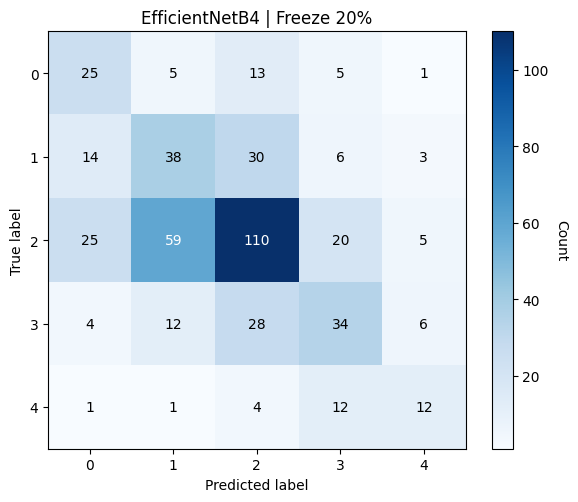

malloc_trim result: 1

=== EfficientNetB4 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 1.5491
→ Val balanced_accuracy: 0.2020
59/59 ━━━━━━━━━━━━━━━━━━━━ 154s 756ms/step - loss: 1.5480
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 1.3482
→ Val balanced_accuracy: 0.2300
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - loss: 1.3479
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 1.2735
→ Val balanced_accuracy: 0.3132
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - loss: 1.2732
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 1.2325
→ Val balanced_accuracy: 0.3372
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 1.2320
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 1.1691
→ Val balanced_accuracy: 0.3694
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 1.1688
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1.1240
→ Val balanced_accuracy: 0.3998
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - loss: 1.1241
Epoc

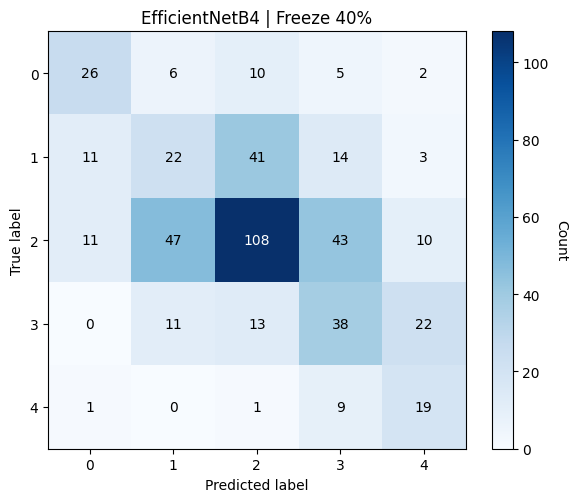

malloc_trim result: 1

=== EfficientNetB4 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 1.5652
→ Val balanced_accuracy: 0.1945
59/59 ━━━━━━━━━━━━━━━━━━━━ 129s 760ms/step - loss: 1.5647
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 1.4424
→ Val balanced_accuracy: 0.2405
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - loss: 1.4420
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 1.3566
→ Val balanced_accuracy: 0.2551
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - loss: 1.3566
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 1.3382
→ Val balanced_accuracy: 0.3009
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 336ms/step - loss: 1.3381
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 1.2994
→ Val balanced_accuracy: 0.4294
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step - loss: 1.2994
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 1.3019
→ Val balanced_accuracy: 0.4383
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - loss: 1.3018
Epoc

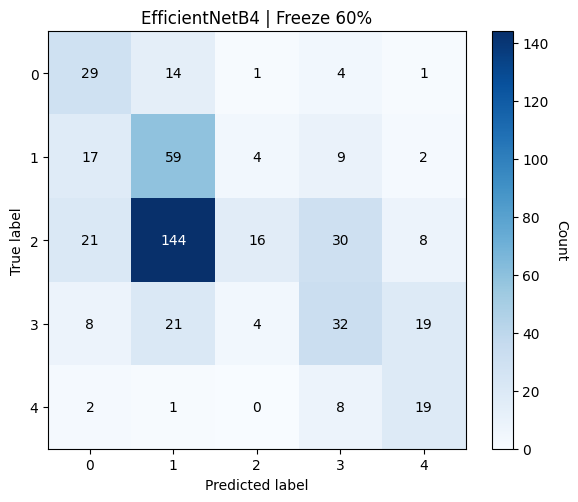

malloc_trim result: 1

=== EfficientNetB4 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 1.5910
→ Val balanced_accuracy: 0.2329
59/59 ━━━━━━━━━━━━━━━━━━━━ 107s 662ms/step - loss: 1.5905
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 1.4942
→ Val balanced_accuracy: 0.2560
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step - loss: 1.4940
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 1.4598
→ Val balanced_accuracy: 0.2842
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - loss: 1.4597
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 1.4505
→ Val balanced_accuracy: 0.2777
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - loss: 1.4504
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 1.4288
→ Val balanced_accuracy: 0.3042
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 302ms/step - loss: 1.4287
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 1.4293
→ Val balanced_accuracy: 0.3602
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - loss: 1.4288
Epoc

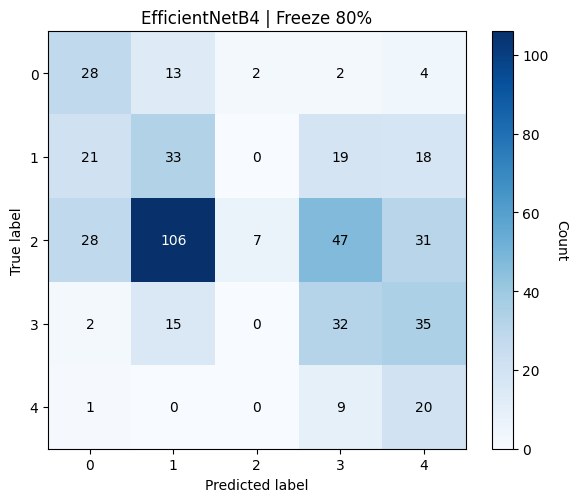

malloc_trim result: 1

=== EfficientNetB4 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 1.6149
→ Val balanced_accuracy: 0.2420
59/59 ━━━━━━━━━━━━━━━━━━━━ 85s 738ms/step - loss: 1.6148
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 1.6039
→ Val balanced_accuracy: 0.3307
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 329ms/step - loss: 1.6039
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 1.6000
→ Val balanced_accuracy: 0.2389
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - loss: 1.6000
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 1.5971
→ Val balanced_accuracy: 0.2592
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step - loss: 1.5971
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 1.5970
→ Val balanced_accuracy: 0.2549
No improvement—stopping early.
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 1.5969
Restoring best weights (balanced_acc=0.3307)
Freeze 100% → BA=0.3307, AUPRC=0.2317


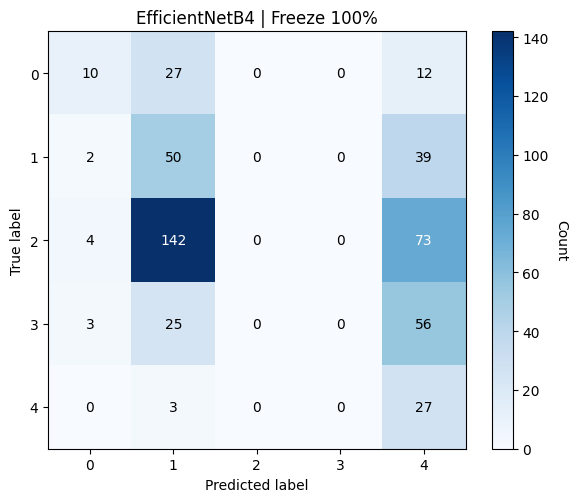

malloc_trim result: 1


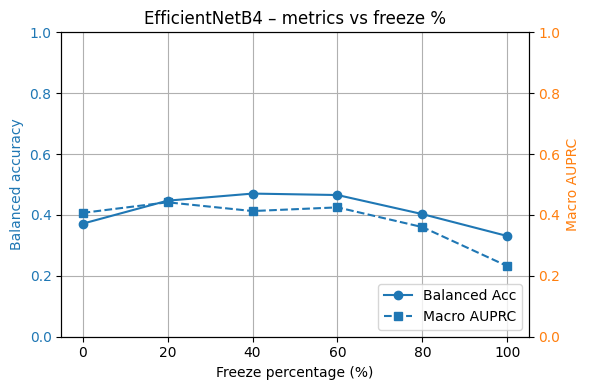

malloc_trim result: 1

=== DenseNet121 | Freeze 0% ===
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 1.5715
→ Val balanced_accuracy: 0.2621
59/59 ━━━━━━━━━━━━━━━━━━━━ 225s 836ms/step - loss: 1.5685
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 1.1641
→ Val balanced_accuracy: 0.2991
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - loss: 1.1631
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.9794
→ Val balanced_accuracy: 0.2375
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 0.9789
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.8878
→ Val balanced_accuracy: 0.3114
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - loss: 0.8874
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.8078
→ Val balanced_accuracy: 0.2707
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - loss: 0.8077
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.7468
→ Val balanced_accuracy: 0.2507
59/59 ━━━━━━━━

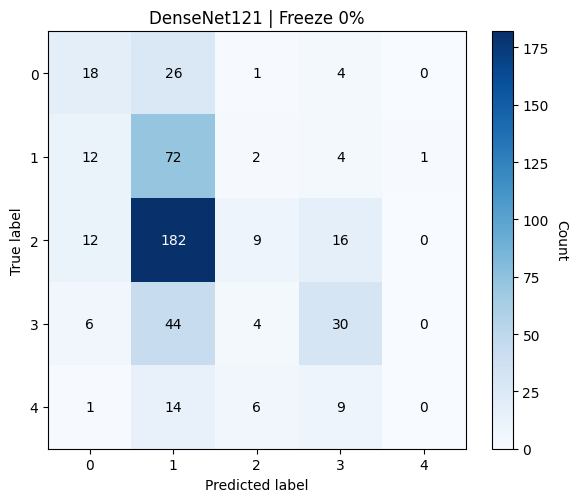

malloc_trim result: 1

=== DenseNet121 | Freeze 20% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 1.6173
→ Val balanced_accuracy: 0.2551
59/59 ━━━━━━━━━━━━━━━━━━━━ 182s 796ms/step - loss: 1.6140
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 1.1570
→ Val balanced_accuracy: 0.3868
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - loss: 1.1563
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 1.0133
→ Val balanced_accuracy: 0.4248
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 312ms/step - loss: 1.0129
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.9426
→ Val balanced_accuracy: 0.4669
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - loss: 0.9417
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.8165
→ Val balanced_accuracy: 0.4559
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 305ms/step - loss: 0.8161
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.7731
→ Val balanced_accuracy: 0.4866
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - loss: 0.7726
Epoch 7

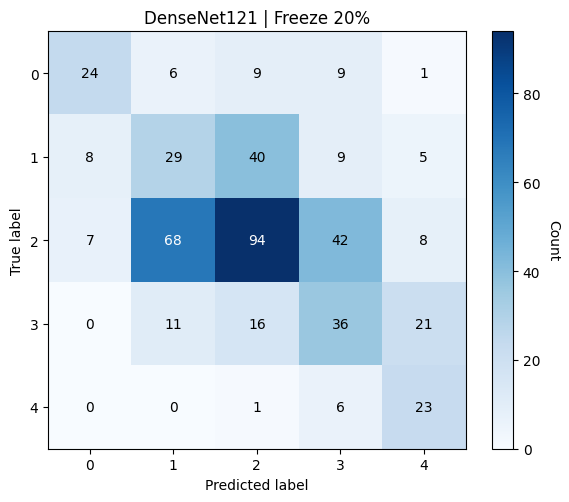

malloc_trim result: 1

=== DenseNet121 | Freeze 40% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1.6715
→ Val balanced_accuracy: 0.3062
59/59 ━━━━━━━━━━━━━━━━━━━━ 145s 676ms/step - loss: 1.6683
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.2141
→ Val balanced_accuracy: 0.3415
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 303ms/step - loss: 1.2134
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 1.0686
→ Val balanced_accuracy: 0.3862
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 1.0682
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1.0320
→ Val balanced_accuracy: 0.4354
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - loss: 1.0315
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.9344
→ Val balanced_accuracy: 0.4844
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - loss: 0.9340
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.8622
→ Val balanced_accuracy: 0.4954
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - loss: 0.8621
Epoch 7

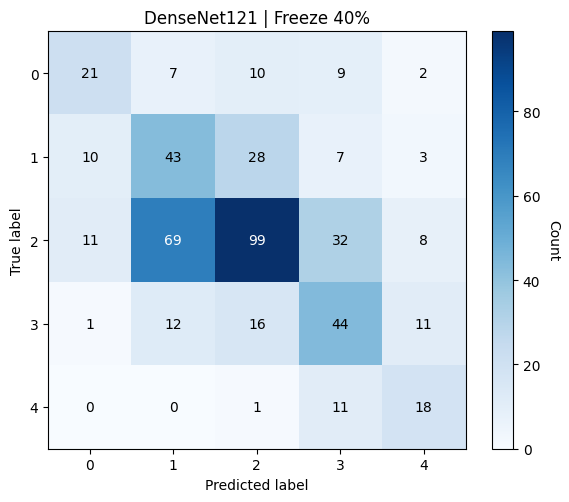

malloc_trim result: 1

=== DenseNet121 | Freeze 60% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1.5469
→ Val balanced_accuracy: 0.2058
59/59 ━━━━━━━━━━━━━━━━━━━━ 120s 799ms/step - loss: 1.5446
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 1.2591
→ Val balanced_accuracy: 0.3413
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - loss: 1.2583
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 1.1210
→ Val balanced_accuracy: 0.4247
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - loss: 1.1207
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1.0656
→ Val balanced_accuracy: 0.4535
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - loss: 1.0651
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.9960
→ Val balanced_accuracy: 0.4412
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - loss: 0.9957
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.9456
→ Val balanced_accuracy: 0.4236
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - loss: 0.9455
Epoch 7

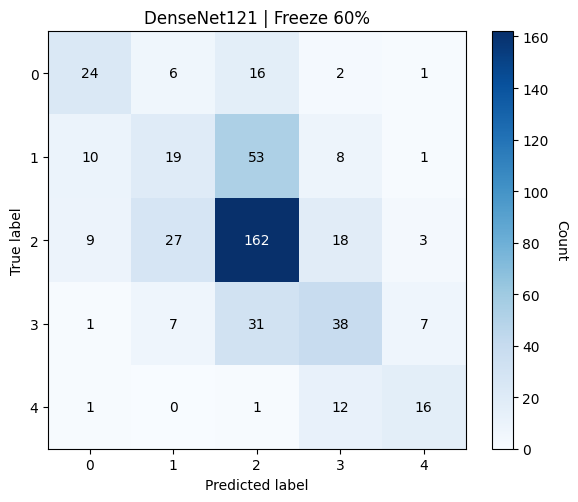

malloc_trim result: 1

=== DenseNet121 | Freeze 80% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 1.7000
→ Val balanced_accuracy: 0.3195
59/59 ━━━━━━━━━━━━━━━━━━━━ 86s 659ms/step - loss: 1.6970
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 1.2897
→ Val balanced_accuracy: 0.3784
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - loss: 1.2896
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 1.2079
→ Val balanced_accuracy: 0.4316
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - loss: 1.2075
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 1.1795
→ Val balanced_accuracy: 0.4352
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - loss: 1.1790
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 1.1258
→ Val balanced_accuracy: 0.4372
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - loss: 1.1253
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 1.0673
→ Val balanced_accuracy: 0.4308
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - loss: 1.0673
Epoch 7/

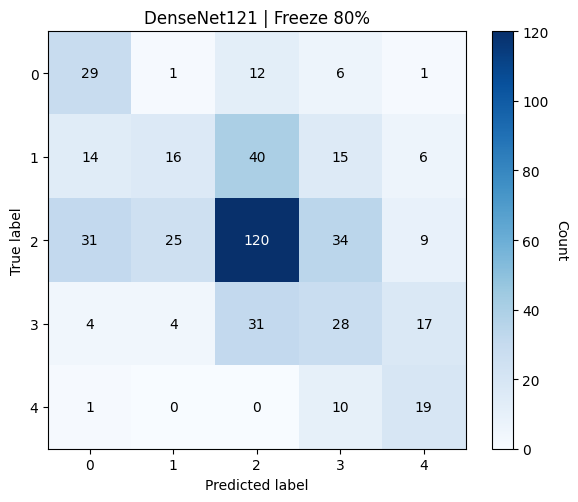

malloc_trim result: 1

=== DenseNet121 | Freeze 100% ===
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 1.7552
→ Val balanced_accuracy: 0.1867
59/59 ━━━━━━━━━━━━━━━━━━━━ 64s 651ms/step - loss: 1.7545
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 1.6347
→ Val balanced_accuracy: 0.2034
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step - loss: 1.6345
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 1.5899
→ Val balanced_accuracy: 0.2081
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - loss: 1.5899
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1.5733
→ Val balanced_accuracy: 0.2481
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 296ms/step - loss: 1.5734
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.5660
→ Val balanced_accuracy: 0.2531
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - loss: 1.5660
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 1.5680
→ Val balanced_accuracy: 0.2791
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - loss: 1.5680
Epoch 7

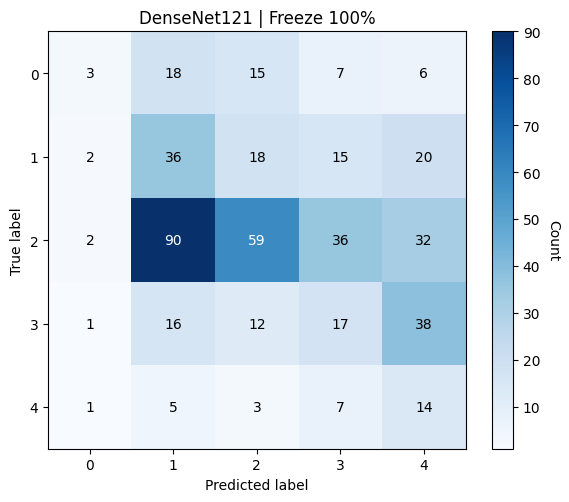

malloc_trim result: 1


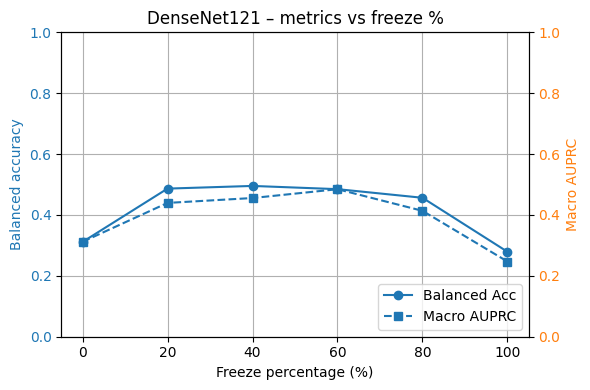

malloc_trim result: 1


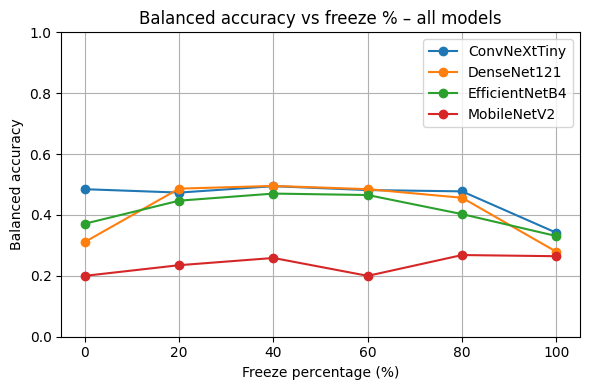

=== Freeze Experiment Results ===
          backbone  freeze_percent  balanced_accuracy  macro_auprc  \
0      MobileNetV2               0           0.200000     0.205430   
1      MobileNetV2              20           0.235001     0.269809   
2      MobileNetV2              40           0.258736     0.284708   
3      MobileNetV2              60           0.200000     0.211540   
4      MobileNetV2              80           0.268357     0.294245   
5      MobileNetV2             100           0.264490     0.256959   
6     ConvNeXtTiny               0           0.484662     0.439006   
7     ConvNeXtTiny              20           0.473527     0.418749   
8     ConvNeXtTiny              40           0.494586     0.463213   
9     ConvNeXtTiny              60           0.481795     0.452721   
10    ConvNeXtTiny              80           0.477552     0.436750   
11    ConvNeXtTiny             100           0.341368     0.293028   
12  EfficientNetB4               0           0.371259   

In [ ]:
freeze_results_df = run_freeze_experiments(
    selected_backbones,
    X_train, y_train_cat,
    X_val, y_val_cat,
    input_shape=(224, 224, 3),
    num_classes=y_train_cat.shape[1],
    freeze_percents=[0, 20, 40, 60, 80, 100],
    epochs=10,
    patience=3,
    batch_size=32,
    autotune=tf.data.AUTOTUNE
)

print("=== Freeze Experiment Results ===")
print(freeze_results_df)

## Evaluation
Analyze freeze experiment results: show top run, correlation, styled table, heatmap, and bar chart

Top run → {'freeze_percent': 40.0, 'balanced_accuracy': 0.49539264388579457}
ρ(trainable_pct, balanced_accuracy) = 0.112 (p=0.603)


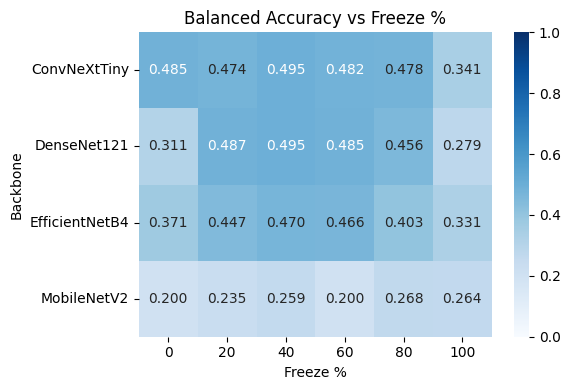

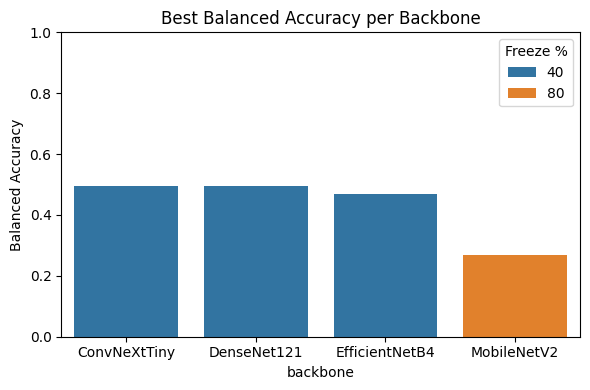

In [ ]:
styled_df = analyze_freeze_results(freeze_results_df)

## Conclusion <br>

1. ConvNeXtTiny: AUC ≈ 46.81
2. DenseNet121: AUC ≈ 44.37
3. EfficientNetB4: AUC ≈ 42.73
4. MobileNetV2: AUC ≈ 23.89

⇒ ConvNeXtTiny has the largest area under the accuracy vs. freeze-percent curve